In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
# load data
data = pd.read_csv('data/joint_dataset/combined_bandgap_data.csv')
# data = data[(data['Value'] >= 0.5) & (data['Value'] <= 5)]
data_comp =  pd.read_csv('materials_filtered.csv')

In [6]:
data
# number of data points in the dataset
print("Number of data points in the dataset:", len(data))
# print total number of data points in Temperature_raw_value column
print("Total number of data points in Temperature_raw_value column:", len(data))
# print the number of data points has nan in Temperature_raw_value column
# print("Number of data points with NaN in Temperature_raw_value column:", data['Temperature_raw_value'].isnull().sum())

Number of data points in the dataset: 1705
Total number of data points in Temperature_raw_value column: 1705


In [7]:
def categorize_compound(formula):
    """
    Categorizes a compound formula into predefined categories.

    Args:
        formula (str): The chemical formula to categorize.

    Returns:
        str: The category of the compound.
    """
    # Define regular expressions for each category, ordered by priority
    categories = {
        # "Double anions": r"(?:(?:O|C(?![a-z])|H(?![a-z])|N(?![a-z])|S(?![a-z])|Se|Te|F(?![a-z])|Cl|Br|I|P(?![a-z])|As|Sb|Si|CO3|SO4|NO3|PO4|CN|SCN|ClO3)\d?){2}",
        "Arsenides": r"As",
        "Antimonides": r"Sb",
        "Silicides": r"Si",
        # "Halides": r"F|Cl|Br|I",
        "Halides": r"F(?![a-z])|Cl(?![a-z])|Br(?![a-z])|I(?![a-z])",
        "Chalcogenides": r"S(?![a-z])|Se(?![a-z])|Te(?![a-z])",
        "Oxides": r"O(?![A-Za-z])",
        "Nitrides": r"N(?![A-Za-z])",
        "Phosphides": r"P(?![A-Za-z])",
        
        "Carbides": r"C(?![A-Za-z])",
        "Hydrides": r"H(?![A-Za-z])",
        "Others": None  # Default category
    }

#     categories = {
#     "Double anions": r"(?:(?:O|C|H|N|S|Se|Te|F|Cl|Br|I|P|As|Sb|Si|CO3|SO4|NO3|PO4|CN|SCN|ClO3)\d?){2}",
#     "Arsenides": r"\bAs\b",
#     "Antimonides": r"\bSb\b",
#     "Silicides": r"\bSi\b",
#     "Halides": r"\bF\b|\bCl\b|\bBr\b|\bI\b",  # Ensures only standalone halogens are matched
#     "Chalcogenides": r"\bS\b|\bSe\b|\bTe\b",
#     "Oxides": r"\bO\b",
#     "Nitrides": r"\bN\b",
#     "Phosphides": r"\bP\b",
#     "Carbides": r"\bC\b",
#     "Hydrides": r"\bH\b",
#     "Others": None  # Default category
# }

    # anion_list = [
    #     "O", "N", "S", "Se", "Te", "F", "Cl", "Br", "I", 
    #     "P", "As", "Sb", "C", "Si", "H", "CO3", "SO4", "NO3", "PO4", "CN", "SCN", "ClO3"
    # ]

    # # Rule for compounds with exactly two distinct anions
    # double_anion_pattern = "|".join(sorted(anion_list, key=len, reverse=True))
    

    # categories = {
    #     "Double anions": double_anion_pattern,
    #     "Arsenides": r"As",
    #     "Antimonides": r"Sb",
    #     "Silicides": r"Si",
    #     "Halides": r"F|Cl|Br|I",
    #     "Chalcogenides": r"S|Se|Te",
    #     "Oxides": r"O(?![A-Za-z])",
    #     "Nitrides": r"N(?![A-Za-z])",
    #     "Phosphides": r"P(?![A-Za-z])",
    #     "Carbides": r"C(?![A-Za-z])",
    #     "Hydrides": r"H(?![A-Za-z])",
    #     "Others": None  # Default category
    # }

    # # Add double anions separately
    # for anion in anion_list:
    #     categories[f"Double anions ({anion})"] = rf"\b{anion}(?!\d)\b"

    

    matched_categories = []

    # # Check for double anions first
    # double_anion_pattern = r"(?:O|C|H)\d"
    # if re.search(double_anion_pattern, formula):
    #     return "Double anions (manual check)"

    # Check each category in priority order
    for category, pattern in categories.items():
        if pattern and re.search(pattern, formula):
            matched_categories.append(category)

    # If multiple categories match, prioritize based on the first match
    if matched_categories:
        return matched_categories[0], len(matched_categories)  # Return the highest-priority match

    # If no category matched, return "Others"
    return "Others", 0

def normalize_formula(x):
    """Return a simple 'Fe2O3' style string from many possible types."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    # already a string
    if isinstance(x, str):
        s = x.strip()
        return s if s else None
    # pymatgen Composition
    try:
        # works for Composition-like objects
        if hasattr(x, "formula"):
            return x.formula.replace(" ", "")
        if hasattr(x, "to_pretty_string"):
            return x.to_pretty_string().replace(" ", "")
    except Exception:
        pass
    # dict like {"Ba":2, "Ti":1, "O":3}
    if isinstance(x, dict):
        # sort by element symbol for determinism
        parts = []
        for el, cnt in sorted(x.items()):
            if cnt == 1 or int(cnt) == cnt:
                cnt_str = "" if int(cnt) == 1 else str(int(cnt))
            else:
                # keep decimals if provided
                cnt_str = str(cnt)
            parts.append(f"{el}{cnt_str}")
        return "".join(parts) if parts else None
    # last resort: string representation
    s = str(x).strip()
    return s if s else None

data['compound_type'], data['Category_count'] = zip(*data['formula'].map(categorize_compound))

# compound category for data_comp
norm = data_comp["composition"].apply(normalize_formula)
pairs = norm.apply(lambda s: categorize_compound(s) if s else ("Others", 0))
data_comp["compound_type"], data_comp["Category_count"] = zip(*pairs)


In [8]:
import pandas as pd
import json
from pathlib import Path
from MatFold import MatFold, cifs_to_dict  # 你的包名如果不同，按实际 import

# 1) 读入 df：第一列必须是 <structureid> 或 <structureid>:<tag>
# df = pd.read_csv("your_dataset.csv")   # 确保 df.iloc[:,0] 是结构 id 字符串

cif_path = "cif_file_filtered"

bulk_data = cifs_to_dict(
    cif_path,
)

# 3) 构建 MatFold
mf = MatFold(
    df=data,
    bulk_dict=bulk_data,
    return_frac=1.0,
    seed=0,
)



# 4) 检查晶系数量/分布
print("n crystal systems:", mf.df["crystalsys"].nunique())
print(mf.df["crystalsys"].value_counts())

output_dir = Path('data/split_json/crystalsys_split/')
output_dir.mkdir(exist_ok=True)

split_crystalsys = mf.create_splits('crystalsys', n_outer_splits=0, n_inner_splits=1, output_dir=str(output_dir), verbose=True)
print(split_crystalsys)

/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountere

n crystal systems: 7
crystalsys
orthorhombic    467
monoclinic      462
tetragonal      228
cubic           213
trigonal        169
triclinic        93
hexagonal        73
Name: count, dtype: int64
The following instances will be removed from possible test sets, as their fraction in the dataset was higher than 1.0 or lower than 0.0: {}.
Default train indices (0):  []
Possible test examples: ['cubic', 'hexagonal', 'monoclinic', 'orthorhombic', 'tetragonal', 'triclinic', 'trigonal']

Splitting: k0, 
['cubic', 'hexagonal', 'monoclinic', 'orthorhombic', 'tetragonal', 'triclinic']
['trigonal']
Individual lengths of indices lists = 1536+169 = 1705. Original total length of dataframe indices = 1705

Splitting: k1, 
['cubic', 'hexagonal', 'orthorhombic', 'tetragonal', 'triclinic', 'trigonal']
['monoclinic']
Individual lengths of indices lists = 1243+462 = 1705. Original total length of dataframe indices = 1705

Splitting: k2, 
['cubic', 'monoclinic', 'orthorhombic', 'tetragonal', 'triclinic', 

/tmp/ipykernel_2477847/4289818431.py:32: DeprecationWarning: `create_splits` is deprecated and will be removed in a future version. Use `create_nested_splits` instead.
  split_crystalsys = mf.create_splits('crystalsys', n_outer_splits=0, n_inner_splits=1, output_dir=str(output_dir), verbose=True)


In [9]:
# def categorize_compound(formula):
#     """
#     Categorizes a compound formula into predefined categories.

#     Args:
#         formula (str): The chemical formula to categorize.

#     Returns:
#         str: The category of the compound.
#     """
#     # Define the list of anions
#     anion_list = [
#         "O", "N", "S", "Se", "Te", "F", "Cl", "Br", "I", 
#         "P", "As", "Sb", "C", "Si", "H", "CO3", "SO4", "NO3", "PO4", "CN", "SCN", "ClO3"
#     ]
    
#     # Create a regex pattern for detecting double anions (distinct anions)
#     sorted_anions = sorted(anion_list, key=len, reverse=True)
#     double_anion_pattern = r"\b(" + "|".join(sorted_anions) + r")\b"
    
#     # Define categories and patterns
#     categories = {
#         "Double anions": None,  # Will be checked separately
#         "Arsenides": r"As",
#         "Antimonides": r"Sb",
#         "Silicides": r"Si",
#         "Halides": r"F|Cl|Br|I",
#         "Chalcogenides": r"S|Se|Te",
#         "Oxides": r"O(?![A-Za-z])",
#         "Nitrides": r"N(?![A-Za-z])",
#         "Phosphides": r"P(?![A-Za-z])",
#         "Carbides": r"C(?![A-Za-z])",
#         "Hydrides": r"H(?![A-Za-z])",
#         "Others": None  # Default category
#     }
    
#     # Check for double anions
#     matches = re.findall(double_anion_pattern, formula)
#     distinct_anions = set(matches)
#     if len(distinct_anions) > 1:
#         return "Double anions"
    
#     # Check each category in priority order
#     matched_categories = []
#     for category, pattern in categories.items():
#         if pattern and re.search(pattern, formula):
#             matched_categories.append(category)

#     # If multiple categories match, prioritize based on the first match
#     if matched_categories:
#         return matched_categories[0]  # Return the highest-priority match

#     # If no category matched, return "Others"
#     return "Others"

# data['compound_type'] = data['formula'].apply(categorize_compound)

In [10]:
# return the total number of rows
print("Total number of rows: ", len(data))
# return the number of unique formulas
print("Number of unique formulas: ", len(data['formula'].unique()))
# get a df for unique formulas and its compound type
unique_formulas = data[['formula', 'compound_type']].drop_duplicates()

Total number of rows:  1705
Number of unique formulas:  1640


In [11]:
# get the number of unique formulas for each compound type
unique_formulas['compound_type'].value_counts()

compound_type
Chalcogenides    585
Oxides           475
Halides          237
Antimonides      121
Arsenides         65
Silicides         63
Nitrides          38
Phosphides        26
Hydrides          16
Carbides           7
Others             7
Name: count, dtype: int64

In [12]:
data['Category_count'].value_counts()
# only keep data with single category
unique_data = data[data['Category_count'] == 1]

In [13]:
data

mpids     formula   bg_mp  bg_exp  num_elements            source  \
0        mp-9770     Ag8GeS6  0.6102   1.450             3  BandgapDatabase1   
1       mp-29678      AgBiS2  0.5212   0.980             3  BandgapDatabase1   
2     mp-1195243       AgP15  1.2132   1.380             2  BandgapDatabase1   
3     mp-1193499  AgPd(IO3)3  1.4039   1.500             4  BandgapDatabase1   
4        mp-1582       As2O3  4.0339   4.500             2  BandgapDatabase1   
...          ...         ...     ...     ...           ...               ...   
1700    mp-22858         TlI  2.3198   2.867             2               DS2   
1701   mp-558747     TlTiPS5  1.1772   1.300             4               DS2   
1702     mp-4842     ZnAl2S4  2.6027   3.500             3               DS2   
1703     mp-1392        ZnP2  0.7480   1.420             2               DS2   
1704   mp-560588         ZnS  2.0776   3.910             2               DS2   

      compound_type  Category_count  
0     Chalcogenides               1  
1     Chalcogenides               1  
2        Phosphides               1  
3           Halides               2  
4         Arsenides               2  
...             ...             ...  
1700        Halides               1  
1701  Chalcogenides               1  
1702  Chalcogenides               1  
1703     Phosphides               1  
1704  Chalcogenides               1  

[1705 rows x 8 columns]

In [14]:
data['Category_count'].value_counts()

Category_count
1    1254
2     406
3      38
0       7
Name: count, dtype: int64

In [15]:
unique_data['compound_type'].value_counts()

compound_type
Chalcogenides    486
Oxides           481
Halides          159
Nitrides          36
Phosphides        27
Antimonides       18
Arsenides         16
Hydrides          16
Silicides          8
Carbides           7
Name: count, dtype: int64

In [16]:
# # for multiple experimental band gaps that match same formula, select the median value of the band gaps
# # Convert the Value column from string to numeric list
# data['Value'] = data['Value'].str.strip('[]').astype(str).str.split(',').apply(lambda x: list(map(float, x)))

# # Expand rows with list values into separate rows
# data = data.explode('Value')
# data['Value'] = data['Value'].astype(float)

# # Group by the formula column and calculate the median for the Value column
# result = data.groupby('formula', as_index=False).agg({
#     'mpids': 'first',
#     'is_stable': 'first',
#     'theoretical': 'first',
#     'band_gap': 'first',
#     'formation_energy_per_atom': 'first',
#     'Value': 'median',
#     'DOI': 'first',
#     'compound_type': 'first'
# })

# # Save the result to a new CSV file
# result.to_csv('bandgap_data_median.csv', index=False)
# print("Processed data saved to 'bandgap_data_median.csv'")

In [17]:
# # load json dataset and convert it to a pandas dataframe
# import json
# with open('data/ds2.json') as f:
#     ds2 = json.load(f)
# ds2 = pd.DataFrame(ds2)
# # transpose the dataframe
# ds2 = ds2.T
# ds2
# # return the number of data points that has 'formula' matched with 'formula' in the original dataset
# print("Number of data points that has 'formula' matched with 'formula' in the original dataset: ", len(ds2[ds2['formula'].isin(data['formula'])]))

In [18]:
# ds2[['formula']].value_counts()

In [19]:
# # split data into training and test sets, 90% training and 10% test
# train = result.sample(frac=0.9, random_state=0)
# test = result.drop(train.index)
# # generate JSON files for training and test sets
# train_json = train.set_index('mpids')['Value'].to_dict()
# train_json = {key: {"bg": value} for key, value in train_json.items()}
# test_json = test.set_index('mpids')['Value'].to_dict()
# test_json = {key: {"bg": value} for key, value in test_json.items()}
# # save the JSON files
# with open('../DomainAdaptationCGCNN/data/experiment_bg/train_data.json', 'w') as json_file:
#     json.dump(train_json, json_file, indent=4)
# with open('../DomainAdaptationCGCNN/data/experiment_bg/test_data.json', 'w') as json_file:
#     json.dump(test_json, json_file, indent=4)
# print("Processed data saved to 'train_data.json' and 'test_data.json'")
# # print number of data points in training and test sets
# print("Number of data points in training set:", len(train))
# print("Number of data points in test set:", len(test))

In [20]:
import json
from pathlib import Path
import pandas as pd

def load_mpids_json(path):
    """
    Load JSON of the form {mpid: {..}} or {mpid: value} into a DataFrame with columns:
      - mpids (str)
      - Value (numeric or raw)
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")

    with p.open() as f:
        j = json.load(f)

    rows = []
    if isinstance(j, dict):
        for k, v in j.items():
            if isinstance(v, dict):
                # common keys used in this notebook: 'bg', 'Value', 'band_gap', 'bg_exp'
                val = v.get("bg")
                if val is None:
                    val = v.get("Value")
                if val is None:
                    val = v.get("band_gap")
                if val is None:
                    val = v.get("bg_exp")
                # fallback to the whole dict if none match
                rows.append({"mpids": str(k), "Value": val if val is not None else v})
            else:
                rows.append({"mpids": str(k), "Value": v})
    elif isinstance(j, list):
        # if list of records, try to normalize
        df_tmp = pd.DataFrame(j)
        if "mpids" in df_tmp.columns:
            df_tmp["mpids"] = df_tmp["mpids"].astype(str)
            return df_tmp
        # if it's a list of mpids
        return pd.DataFrame({"mpids": [str(x) for x in j]})
    else:
        raise ValueError("Unrecognized JSON structure")

    df = pd.DataFrame(rows)
    # try to coerce Value to numeric if possible
    df["Value"] = pd.to_numeric(df["Value"], errors="ignore")
    return df

# Load train/test JSONs
train_path = "data/joint_dataset/train_data.json"
test_path = "data/joint_dataset/test_data.json"

train_data = load_mpids_json(train_path)
test_data = load_mpids_json(test_path)

# Ensure the main 'data' table and mpids are strings for a correct merge.
# (If the notebook's `data` DataFrame hasn't been defined yet, this will raise NameError.)
train_data["mpids"] = train_data["mpids"].astype(str)
test_data["mpids"] = test_data["mpids"].astype(str)
data["mpids"] = data["mpids"].astype(str)

# Merge compound_type from main `data` onto train/test by mpids
train_data = train_data.merge(data[["mpids", "compound_type"]], on="mpids", how="left")
test_data = test_data.merge(data[["mpids", "compound_type"]], on="mpids", how="left")

# Quick summary
print("Train: total mpids =", len(train_data), ", matched compound_type =", train_data["compound_type"].notna().sum())
print("Test:  total mpids =", len(test_data),  ", matched compound_type =", test_data["compound_type"].notna().sum())

# Optionally inspect unmatched mpids
unmatched_train = train_data[train_data["compound_type"].isna()]
unmatched_test = test_data[test_data["compound_type"].isna()]
if len(unmatched_train):
    print("Unmatched train mpids (sample):", unmatched_train["mpids"].head().tolist())
if len(unmatched_test):
    print("Unmatched test mpids (sample):", unmatched_test["mpids"].head().tolist())

# The variables `train_data` and `test_data` now contain a 'compound_type' column and can be used by subsequent cells.

/tmp/ipykernel_2477847/504112945.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df["Value"] = pd.to_numeric(df["Value"], errors="ignore")


Train: total mpids = 1368 , matched compound_type = 1368
Test:  total mpids = 337 , matched compound_type = 337


In [21]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # ======================
# # Font and style setup
# # ======================
# plt.rcParams.update({
#     'font.size': 12,
#     'axes.titlesize': 14,
#     'axes.labelsize': 12,
#     'xtick.labelsize': 10,
#     'ytick.labelsize': 10,
#     'legend.fontsize': 11
# })

# # ======================
# # Category setup
# # ======================
# category_order = [
#     "Oxides", "Halides", "Chalcogenides", "Silicides", "Antimonides",
#     "Arsenides", "Nitrides", "Phosphides", "Hydrides", "Others", "Carbides"
# ]

# custom_palette = {
#     "Antimonides": "#ea5545",
#     "Arsenides": "#f46a9b",
#     "Carbides": "#ef9b20",
#     "Chalcogenides": "#edbf33",
#     "Halides": "#ede15b",
#     "Hydrides": "#bdcf32",
#     "Nitrides": "#87bc45",
#     "Oxides": "#27aeef",
#     "Phosphides": "#b33dc6",
#     "Silicides": "#9b19f5",
#     "Others": "#aaaaaa"
# }

# # ======================
# # Count by category
# # ======================
# data_category_counts = (
#     data_comp['compound_type']
#     .value_counts()
#     .reindex(category_order, fill_value=0)
# )

# train_category_counts = train_data['compound_type'].value_counts()
# test_category_counts = test_data['compound_type'].value_counts()

# combined_data = pd.concat([train_data, test_data])
# combined_category_counts = (
#     combined_data['compound_type']
#     .value_counts()
#     .reindex(category_order, fill_value=0)
# )

# data_band_gap = data_comp['bg']
# combined_values = pd.concat([train_data['Value'], test_data['Value']])

# # ======================
# # Plot helper function
# # ======================
# def plot_bar(ax, category_counts, title, gray_missing=False):
#     bar_colors = []
#     for cat in category_counts.index:
#         if gray_missing and category_counts[cat] == 0:
#             bar_colors.append("#cccccc")
#         else:
#             bar_colors.append(custom_palette.get(cat, "#999999"))

#     ax.bar(category_counts.index, category_counts.values, color=bar_colors, alpha=0.9)
#     ax.set_ylabel('Count')
#     ax.set_title(title, pad=8)
#     ax.tick_params(axis='x', rotation=45)
#     ax.set_xlabel("Compound category")

# # ======================
# # Figure layout
# # ======================
# fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# # A) Computational dataset (category count)
# plot_bar(axs[0, 0], data_category_counts, "Computational (Pre-training) dataset")
# axs[0, 0].tick_params(labelbottom=False)

# # B) Computational dataset (band gap)
# axs[0, 1].hist(data_band_gap, bins=20, color='blue', edgecolor='black', alpha=0.7, range=(0.5, 5))
# axs[0, 1].set_title("Band gap distribution (computational dataset)", pad=8)
# axs[0, 1].set_ylabel("Count")
# axs[0, 1].tick_params(labelbottom=False)

# # C) Experimental dataset (category count)
# plot_bar(axs[1, 0], combined_category_counts, "Experimental (Fine-tuning + Evaluation) dataset", gray_missing=True)

# # D) Experimental dataset (band gap)
# axs[1, 1].hist(combined_values, bins=20, color='green', edgecolor='black', alpha=0.7, range=(0.5, 5))
# axs[1, 1].set_title("Band gap distribution (experimental dataset)", pad=8)
# axs[1, 1].set_xlabel("Band gap (eV)")
# axs[1, 1].set_ylabel("Count")

# # ======================
# # Subplot labels (A–D)
# # ======================
# subplot_labels = ['A', 'B', 'C', 'D']
# for ax, label in zip(axs.flat, subplot_labels):
#     ax.text(-0.1, 1.1, label, transform=ax.transAxes,
#             fontsize=14, fontweight="bold", va="top", ha="left")

# # ======================
# # Figure fine-tuning
# # ======================
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.3, wspace=0.25)
# plt.savefig("final_data_distribution.pdf", bbox_inches="tight")
# plt.show()


In [22]:
category_order = [
    "Oxides", "Halides", "Chalcogenides", "Silicides", "Antimonides",
    "Arsenides", "Nitrides", "Phosphides", "Hydrides", "Others", "Carbides"
]

# ======================
# Count by category
# ======================
data_category_counts = (
    data_comp['compound_type']
    .value_counts()
    .reindex(category_order, fill_value=0)
)


train_category_counts = train_data['compound_type'].value_counts()
test_category_counts = test_data['compound_type'].value_counts()

combined_data = pd.concat([train_data, test_data])
combined_category_counts = (
    combined_data['compound_type']
    .value_counts()
    .reindex(category_order, fill_value=0)
)

data_band_gap = data_comp['bg']
combined_values = pd.concat([train_data['Value'], test_data['Value']])


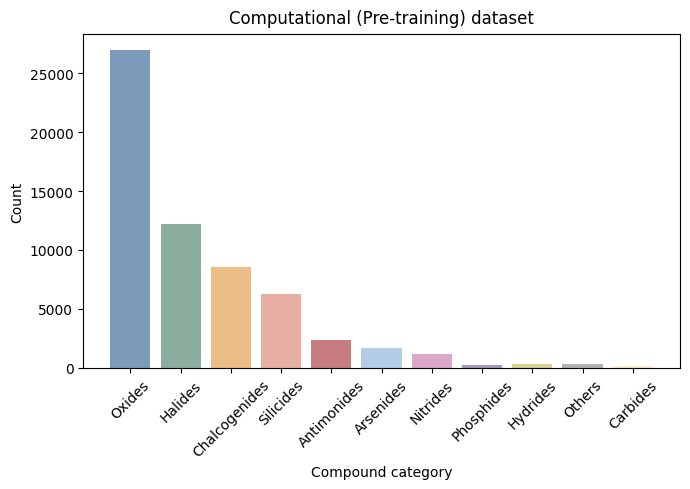

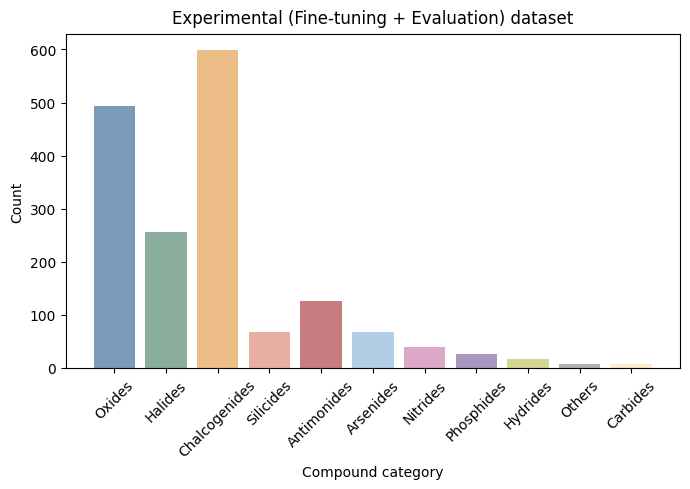

In [23]:
import os
import matplotlib.pyplot as plt

# ======================
# Ensure figs/ folder exists
# ======================
os.makedirs("figs", exist_ok=True)

# ======================
# Category setup
# ======================
category_order = [
    "Oxides", "Halides", "Chalcogenides", "Silicides", "Antimonides",
    "Arsenides", "Nitrides", "Phosphides", "Hydrides", "Others", "Carbides"
]

custom_palette = {
    "Oxides": "#6e8fb2",
    "Halides": "#7da494",
    "Chalcogenides": "#eab67a",
    "Silicides": "#e5a79a",
    "Antimonides": "#c16e71",
    "Arsenides": "#abc8e5",
    "Nitrides": "#d8a0c1",
    "Phosphides": "#9f8db8",
    "Hydrides": "#d0d08a",
    "Carbides": "#ffe8c9",
    "Others": "#aaaaaa"
}

# ======================
# Plot helper function
# ======================
def plot_bar(ax, category_counts, title, gray_missing=False):
    bar_colors = []
    for cat in category_counts.index:
        if gray_missing and category_counts[cat] == 0:
            bar_colors.append("#cccccc")
        else:
            bar_colors.append(custom_palette.get(cat, "#999999"))

    ax.bar(category_counts.index, category_counts.values, color=bar_colors, alpha=0.9)
    ax.set_ylabel('Count')
    ax.set_title(title, pad=8)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Compound category")

# ======================
# Figure 1: Computational dataset (category count)
# ======================
fig1, ax1 = plt.subplots(figsize=(7, 5))



plot_bar(ax1, data_category_counts, "Computational (Pre-training) dataset")
ax1.set_xlabel("Compound category")

plt.tight_layout()
plt.savefig("figs/fig_category_computational.pdf", bbox_inches="tight", dpi=600)
plt.savefig("figs/fig_category_computational.png", bbox_inches="tight", dpi=300)
plt.show()

# ======================
# Figure 2: Experimental dataset (category count)
# ======================
fig2, ax2 = plt.subplots(figsize=(7, 5))

plot_bar(
    ax2,
    combined_category_counts,
    "Experimental (Fine-tuning + Evaluation) dataset",
    gray_missing=True,
)
ax2.set_xlabel("Compound category")

plt.tight_layout()
plt.savefig("figs/fig_category_experimental.pdf", bbox_inches="tight", dpi=600)
plt.savefig("figs/fig_category_experimental.png", bbox_inches="tight", dpi=300)
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_donut_all_labels(category_counts, title, palette, figsize=(7, 7)):
    labels = category_counts.index.tolist()
    sizes = category_counts.values.astype(float)
    total = sizes.sum()
    percentages = sizes / total * 100

    colors = [palette.get(cat, "#999999") for cat in labels]

    # Create plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Donut wedges
    wedges, _ = ax.pie(
        sizes,
        colors=colors,
        startangle=90,
        wedgeprops=dict(width=0.35, edgecolor='white')
    )

    # Draw ALL labels outside with leader lines
    for i, wedge in enumerate(wedges):
        pct = percentages[i]
        label = labels[i]

        # Mid-angle of wedge
        angle = 0.5 * (wedge.theta1 + wedge.theta2)
        angle_rad = np.deg2rad(angle)

        # Position on donut edge
        x = np.cos(angle_rad)
        y = np.sin(angle_rad)

        # Label position outside the donut
        label_radius = 1.25
        lx = label_radius * np.cos(angle_rad)
        ly = label_radius * np.sin(angle_rad)

        # Label text
        text = f"{label}\n{pct:.1f}%"

        # Annotate with leader line
        ax.annotate(
            text,
            xy=(x, y),
            xytext=(lx, ly),
            ha="center",
            va="center",
            fontsize=10,
            arrowprops=dict(
                arrowstyle="-",
                color=colors[i],
                lw=1.2,
                shrinkA=0,
                shrinkB=0,
            )
        )

    ax.set_title(title, fontsize=14, pad=12)
    plt.tight_layout()
    return fig, ax


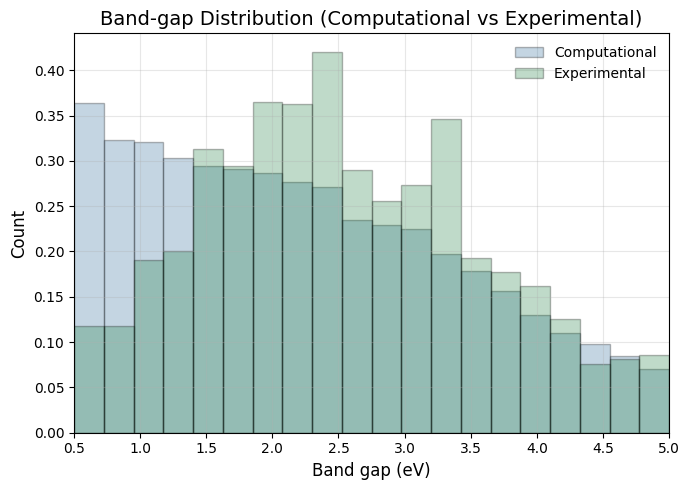

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# data_band_gap = data_comp['bg']
# experimental_bg = combined_values

def show_overlapped_hist(comp_values, exp_values, title, bins=20):
    plt.figure(figsize=(7, 5))

    # Common bin edges (0.5–5 eV, same as before)
    bin_edges = np.linspace(0.5, 5, bins + 1)

    plt.hist(
        comp_values,
        bins=bin_edges,
        density=True,
        color="#2b6a99",
        alpha=0.28,
        label="Computational",
        edgecolor="black"
    )

    plt.hist(
        exp_values,
        bins=bin_edges,
        density=True,
        color="#1b7c3d",
        alpha=0.28,
        label="Experimental",
        edgecolor="black"
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Band gap (eV)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xlim(0.5, 5)
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("figs/" + title.lower().replace(" ", "_") + ".pdf", bbox_inches="tight", dpi=600)
    plt.show()


# ==== USAGE ====

show_overlapped_hist(
    data_band_gap,
    combined_values,
    "Band-gap Distribution (Computational vs Experimental)"
)



In [57]:
"""
periodic-table heatmap for element frequency in a dataset.
"""

from ast import literal_eval
from collections import Counter
from pathlib import Path
from typing import Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from pymatgen.core import Composition, Element


def _iter_elements_from_formulas(formulas: Iterable[str]) -> Iterable[Iterable[str]]:
    for formula in formulas:
        if not isinstance(formula, str):
            continue
        try:
            composition = Composition(formula)
        except Exception as exc:
            print(f"Skipping formula {formula!r}: {exc}")
            continue
        yield [el.symbol for el in composition.elements]


def _iter_elements_from_column(entries: Iterable) -> Iterable[Iterable[str]]:
    for entry in entries:
        if entry is None or (isinstance(entry, float) and np.isnan(entry)):
            continue
        if isinstance(entry, str):
            try:
                parsed = literal_eval(entry)
            except Exception as exc:
                print(f"Could not parse element list {entry!r}: {exc}")
                continue
        else:
            parsed = entry
        if isinstance(parsed, (list, tuple)):
            yield [str(el).strip(" '\"") for el in parsed if el]


def load_element_frequencies(
    csv_path: Path | str,
    formula_column: Optional[str] = None,
    elements_column: Optional[str] = None,
) -> Counter:
    """Count how many rows/compounds contain each element (count once per compound)."""
    csv_path = Path(csv_path)

    if not formula_column and not elements_column:
        raise ValueError("Provide at least formula_column or elements_column")

    df = pd.read_csv(csv_path)
    frequency = Counter()

    sources = []
    if formula_column:
        sources.append(("formula", formula_column))
    if elements_column:
        sources.append(("elements", elements_column))

    element_lists: Optional[Iterable[Iterable[str]]] = None
    for source_type, column in sources:
        if column not in df.columns:
            continue
        series = df[column].dropna()
        if source_type == "formula":
            element_lists = _iter_elements_from_formulas(series)
        else:
            element_lists = _iter_elements_from_column(series)
        break

    if element_lists is None:
        missing = ", ".join(repr(col) for _, col in sources) or "specified columns"
        raise KeyError(f"None of the columns {missing} were found in {csv_path}. "
                       f"Available columns: {list(df.columns)}")

    for element_list in element_lists:
        for symbol in set(element_list):  # count once per compound
            frequency[symbol] += 1

    return frequency


def build_heatmap_frames(frequency: Counter) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Create data and label frames aligned with periodic table layout."""
    max_rows, max_cols = 9, 18
    heat = np.full((max_rows, max_cols), np.nan)
    labels = np.empty((max_rows, max_cols), dtype=object)

    period_labels = {
        1: "Period 1",
        2: "Period 2",
        3: "Period 3",
        4: "Period 4",
        5: "Period 5",
        6: "Period 6",
        7: "Period 7",
        8: "Lanthanides",
        9: "Actinides",
    }

    for atomic_number in range(1, 119):
        element = Element.from_Z(atomic_number)
        symbol = element.symbol
        count = frequency.get(symbol, 0)

        # Map lanthanides/actinides to dedicated rows.
        if 57 <= atomic_number <= 71:
            row = 8
            group = atomic_number - 54  # Align La under group 3.
        elif 89 <= atomic_number <= 103:
            row = 9
            group = atomic_number - 86  # Align Ac under group 3.
        else:
            row = element.row
            group = element.group

        if group is None or not (1 <= group <= max_cols):
            continue

        row_idx = row - 1
        col_idx = group - 1

        heat[row_idx, col_idx] = count
        labels[row_idx, col_idx] = symbol

    index = [period_labels[i + 1] for i in range(max_rows)]
    columns = list(range(1, max_cols + 1))

    heat_df = pd.DataFrame(heat, index=index, columns=columns)
    label_df = pd.DataFrame(labels, index=index, columns=columns)
    return heat_df, label_df


def plot_heatmap(
    heat_df: pd.DataFrame,
    label_df: pd.DataFrame,
    output_path: Optional[Path | str] = None,
    log_scale: bool = True,
    color_la_ac: bool = False,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (18, 8),
    show_colorbar: bool = True,
    shared_norm: Optional[LogNorm] = None,
    shared_cbar_label: Optional[str] = None,
) -> plt.Axes:
    """
    Render the heatmap.
    Notebook behavior:
      - if ax is None -> create fig+ax and show() by default
      - if output_path provided -> save figure
    """
    own_axis = ax is None
    if own_axis:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    heat_df = heat_df.copy()
    label_df = label_df.copy()

    # La/Ac placeholders
    if color_la_ac:
        lan_sum = float(np.nansum(heat_df.loc["Lanthanides"].values))
        act_sum = float(np.nansum(heat_df.loc["Actinides"].values))
        heat_df.at["Period 6", 3] = lan_sum
        heat_df.at["Period 7", 3] = act_sum
        label_df.at["Period 6", 3] = "La"
        label_df.at["Period 7", 3] = "Ac"
    else:
        label_df.at["Period 6", 3] = "La"
        label_df.at["Period 7", 3] = "Ac"
        heat_df.at["Period 6", 3] = np.nan
        heat_df.at["Period 7", 3] = np.nan

    def add_spacer(df: pd.DataFrame, fill_value=np.nan, dtype=None) -> pd.DataFrame:
        idx = df.index.tolist()
        insert_pos = idx.index("Period 7") + 1
        spacer = pd.DataFrame(
            [[fill_value] * df.shape[1]],
            index=[" "],
            columns=df.columns,
            dtype=dtype,
        )
        return pd.concat([df.iloc[:insert_pos], spacer, df.iloc[insert_pos:]])

    display_heat_df = add_spacer(heat_df)
    display_label_df = add_spacer(label_df, fill_value=None, dtype=object)

    plot_df = display_heat_df.copy()

    norm = shared_norm
    cbar_label = shared_cbar_label if shared_cbar_label is not None else "Compound count"

    if log_scale and norm is None:
        plot_df = display_heat_df.where(display_heat_df > 0)
        valid_values = plot_df.values[np.isfinite(plot_df.values)]
        if valid_values.size == 0:
            log_scale = False
            plot_df = display_heat_df
        else:
            min_nonzero = valid_values.min()
            max_value = valid_values.max()
            if min_nonzero == max_value:
                log_scale = False
                plot_df = display_heat_df
            else:
                norm = LogNorm(vmin=min_nonzero, vmax=max_value)
                cbar_label = "Compound count (log scale)"

    if (not log_scale) and norm is None:
        plot_df = display_heat_df

    cmap = sns.color_palette("viridis", as_cmap=True)
    cmap.set_bad(color="white")

    mask = display_heat_df.isna()
    cbar_kws = {"label": cbar_label, "shrink": 0.6} if show_colorbar else None

    ax = sns.heatmap(
        plot_df,
        mask=mask,
        cmap=cmap,
        linewidths=0,
        square=True,
        norm=norm,
        cbar=show_colorbar,
        cbar_kws=cbar_kws,
        ax=ax,
    )
    ax.set_facecolor("white")

    max_value = np.nanmax(display_heat_df.values)

    for row_idx in range(display_label_df.shape[0]):
        for col_idx in range(display_label_df.shape[1]):
            symbol = display_label_df.iat[row_idx, col_idx]
            if not symbol:
                continue

            text_color = "black"

            rect = Rectangle(
                (col_idx, row_idx),
                1,
                1,
                fill=False,
                edgecolor="#424242",
                linewidth=0.8,
            )
            ax.add_patch(rect)

            ax.text(
                col_idx + 0.5,
                row_idx + 0.5,
                symbol,
                ha="center",
                va="center",
                color=text_color,
                fontsize=10,
                fontweight="bold",
            )

    ax.set_ylabel("")
    ax.set_xlabel("Group")
    if title:
        ax.set_title(title)

    fig.tight_layout()

    if output_path:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")

    # Notebook 里如果是 own_axis，就直接 show（不要 close）
    if own_axis:
        plt.show()

    return ax


def print_top_elements(label: str, frequency: Counter, top_n: int = 10) -> None:
    print(f"Top elements ({label}):")
    for symbol, count in frequency.most_common(top_n):
        print(f"{symbol:>3}: {count}")


def run_heatmap_from_csv(
    csv_path: Path | str,
    formula_column: str = "formula",
    elements_column: Optional[str] = None,
    title: Optional[str] = None,
    color_la_ac: bool = False,
    log_scale: bool = True,
    output_path: Optional[Path | str] = None,
    show_colorbar: bool = True,
) -> Tuple[Counter, pd.DataFrame, pd.DataFrame, plt.Axes]:
    """One-liner helper for notebooks."""
    freq = load_element_frequencies(
        csv_path, formula_column=formula_column, elements_column=elements_column
    )
    heat_df, label_df = build_heatmap_frames(freq)
    if title:
        print_top_elements(title, freq)
    ax = plot_heatmap(
        heat_df,
        label_df,
        title=title,
        color_la_ac=color_la_ac,
        log_scale=log_scale,
        output_path=output_path,
        show_colorbar=show_colorbar,
    )
    return freq, heat_df, label_df, ax


In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlapped_hist(ax, comp_values, exp_values, title=None, bins=20):
    # Common bin edges (0.5–5 eV)
    bin_edges = np.linspace(0.5, 5, bins + 1)

    ax.hist(
        comp_values,
        bins=bin_edges,
        density=True,
        orientation="horizontal",
        color="#2b6a99",
        alpha=0.28,
        label="Computational",
        edgecolor="black",
    )

    ax.hist(
        exp_values,
        bins=bin_edges,
        density=True,
        orientation="horizontal",
        color="#1b7c3d",
        alpha=0.28,
        label="Experimental",
        edgecolor="black",
    )

    if title:
        ax.set_title(title, fontsize=14)

    ax.set_ylabel("Band gap (eV)", fontsize=12)
    ax.set_xlabel("Density", fontsize=12)
    ax.set_ylim(0.5, 5)
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)


/tmp/ipykernel_2477847/221020227.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_2477847/221020227.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


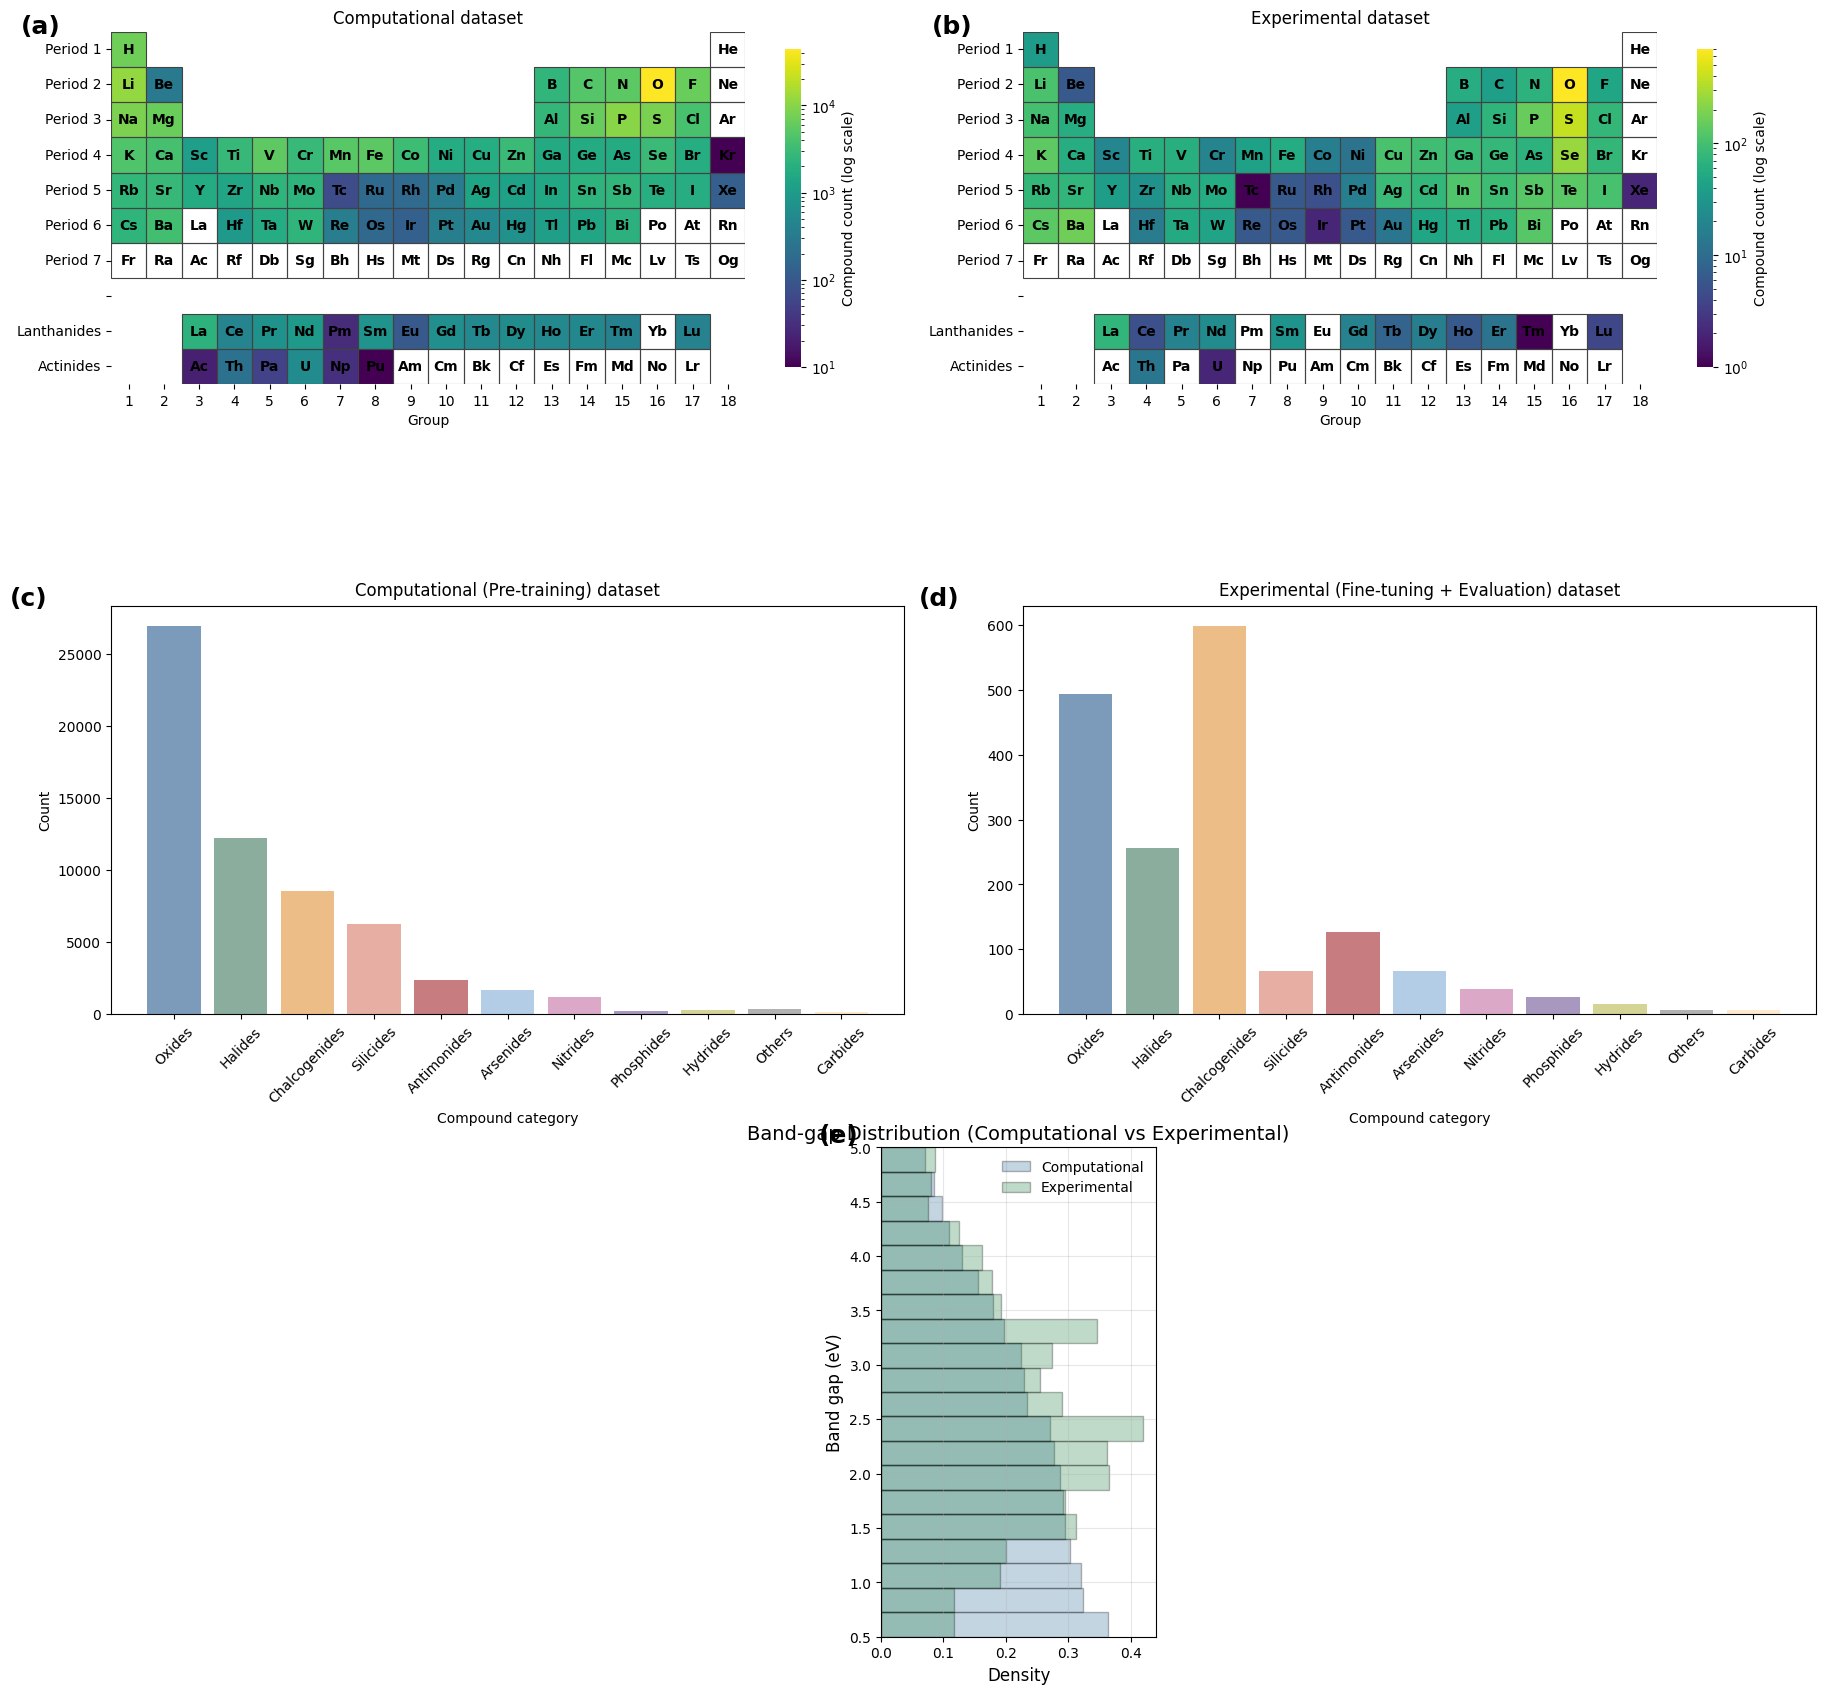

In [69]:
import os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

fig = plt.figure(figsize=(22, 22))
gs = fig.add_gridspec(
    3, 2,
    height_ratios=[1.3, 1.0, 1.2],  # 最后一行给直方图
    hspace=0.28,
    wspace=0.15,
)

ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])
ax_c = fig.add_subplot(gs[1, 0])
ax_d = fig.add_subplot(gs[1, 1])
ax_e = fig.add_subplot(gs[2, :])  
# 原始位置
pos = ax_e.get_position()

# 手动缩进左右边界（单位是 figure fraction）
ax_e.set_position([
    pos.x0 + 0.35,   # 左边向右收
    pos.y0,
    pos.width - 0.65,  # 宽度减少
    pos.height,
])


# (a) Computational dataset – element frequency
freq_comp = load_element_frequencies("materials_filtered.csv", formula_column="composition")
heat_comp, label_comp = build_heatmap_frames(freq_comp)
plot_heatmap(heat_comp, label_comp, ax=ax_a, title="Computational dataset", log_scale=True, show_colorbar=True)

# (b) Experimental dataset – element frequency
freq_exp = load_element_frequencies("data/joint_dataset/combined_bandgap_data.csv", formula_column="formula")
heat_exp, label_exp = build_heatmap_frames(freq_exp)
plot_heatmap(heat_exp, label_exp, ax=ax_b, title="Experimental dataset", log_scale=True, show_colorbar=True)

# (c) Computational category distribution
plot_bar(ax_c, data_category_counts, "Computational (Pre-training) dataset")
ax_c.set_xlabel("Compound category")

# (d) Experimental category distribution
plot_bar(ax_d, combined_category_counts, "Experimental (Fine-tuning + Evaluation) dataset", gray_missing=True)
ax_d.set_xlabel("Compound category")

plot_overlapped_hist(
    ax_e,
    data_band_gap,        # 你的 computational band gap array/series
    combined_values,      # 你的 experimental band gap array/series
    title="Band-gap Distribution (Computational vs Experimental)",
    bins=20,
)

for ax, lab in zip([ax_a, ax_b, ax_c, ax_d, ax_e], ["(a)", "(b)", "(c)", "(d)", "(e)"]):
    ax.text(
        -0.08, 1.05, lab,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="bold",
        va="top",
        ha="right",
    )


fig.savefig("figs/fig_abcde_combined.pdf", bbox_inches="tight", dpi=600)
fig.savefig("figs/fig_abcde_combined.png", bbox_inches="tight", dpi=300)
plt.show()



In [63]:
# PCA and t-SNE for the unique_data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features

# X: your (N, d) matrix of encoded features
# compound_types: list or Series of length N
x_dataset=CIFData(mpids_bg=unique_data[['mpids', 'band_gap']],cif_folder='cif_file', init_file='encoding/atom_init.json',
                                max_nbrs=14, radius=7, randomize=False)
X, y = extract_features(x_dataset)
compound_types = unique_data['compound_type']

# Generate 10 colors from the "Set2" palette
colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", "#9b19f5","#d7e1ee"]
# Define a fixed color palette for each compound type (sorted order)
unique_compounds = sorted(list(np.unique(compound_types)))  # Convert NumPy array to a Python list
fixed_palette = {compound: color for compound, color in zip(unique_compounds, colors)}



# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter Plot with Improved Legend
plt.figure(figsize=(8,6))
ax=sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=compound_types,
    palette=fixed_palette,
    legend='full'
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Manually fix the order of legend categories
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: unique_compounds.index(x[1]))  # Sort by predefined order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Improve legend visibility with fixed order
plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=1.5, frameon=True, shadow=True, title="Compound Type")


plt.tight_layout()

# save plot as pdf
plt.savefig('PCA_plot.pdf', bbox_inches='tight')

plt.show()


KeyError: "['band_gap'] not in index"

/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


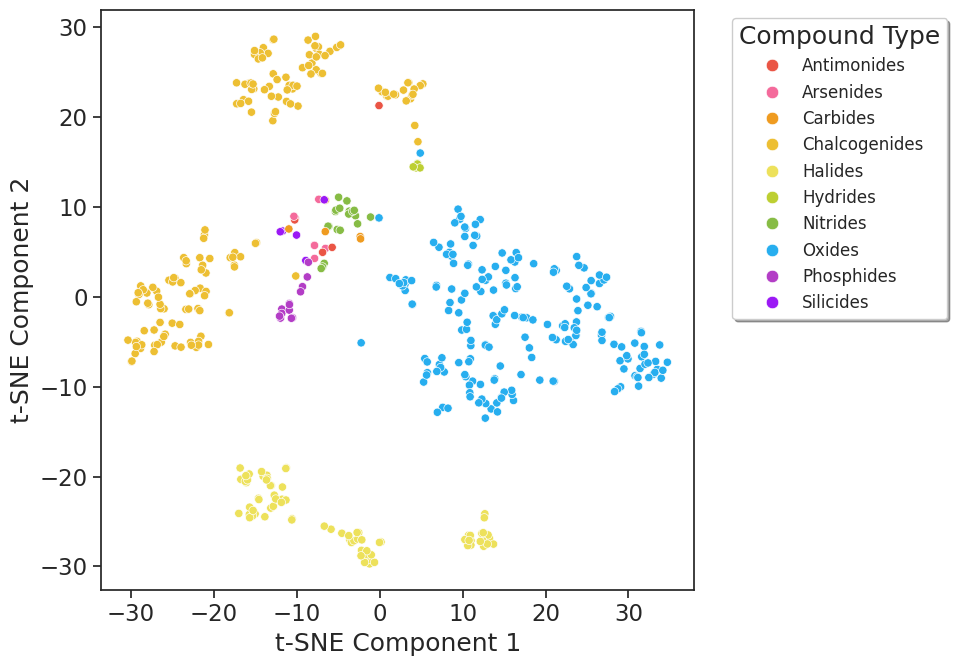

In [ ]:
from sklearn.manifold import TSNE

# Convert compound_types to a NumPy array for proper indexing
compound_types_array = np.array(compound_types)  # Ensure it's indexed correctly

# Step 1: Reduce dimensionality with PCA for faster t-SNE
pca = PCA(n_components=10, random_state=42)  # Reduce to 10D
X_pca = pca.fit_transform(X)

# Step 2: Sample a subset of data for faster computation
subset_size = min(500, X_pca.shape[0])  # Use 500 samples max
subset_indices = np.random.choice(X_pca.shape[0], subset_size, replace=False)
X_subset = X_pca[subset_indices]
compound_types_subset = compound_types_array[subset_indices]  # Fixed indexing

# Step 3: Run t-SNE
tsne = TSNE(n_components=2, perplexity=15, n_iter=400, method='barnes_hut', random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Step 5: Plot with fixed colors
plt.figure(figsize=(10, 7))
ax=sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=compound_types_subset,
    palette=fixed_palette,  # Use the predefined color mapping
    legend='full'
)

# Manually fix the order of legend categories
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: unique_compounds.index(x[1]))  # Sort by predefined order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Improve legend visibility with fixed order
plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=1.5, frameon=True, shadow=True, title="Compound Type")


plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Visualization of Encoded Features (Fixed Colors)")

plt.tight_layout()

# save plot as pdf
plt.savefig('tSNE_plot.pdf', bbox_inches='tight')

plt.show()

/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


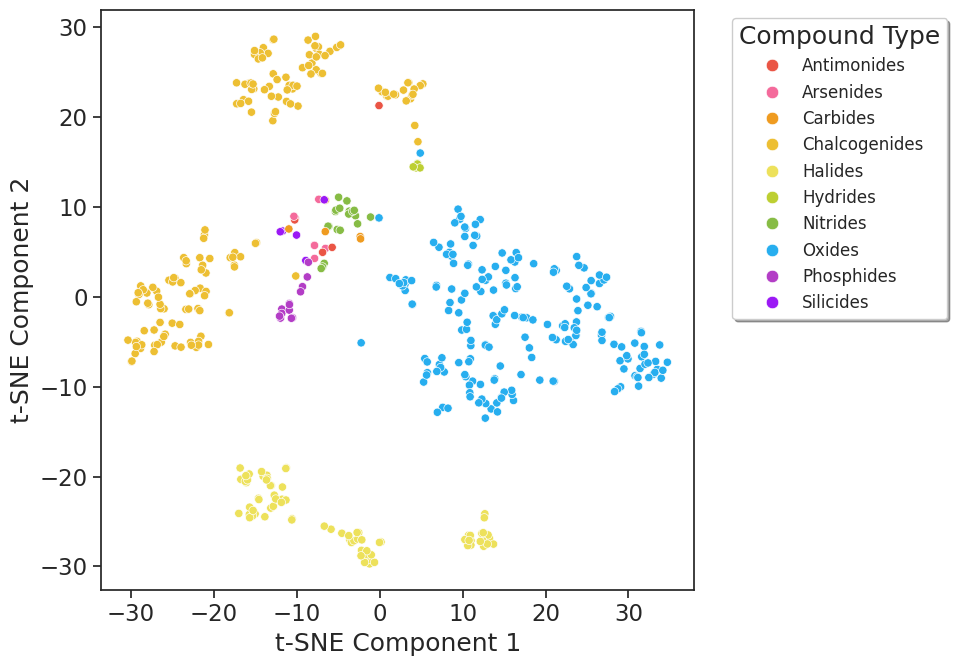

In [ ]:
from sklearn.manifold import TSNE

# Convert compound_types to a NumPy array for proper indexing
compound_types_array = np.array(compound_types)  # Ensure it's indexed correctly

# Step 1: Reduce dimensionality with PCA for faster t-SNE
pca = PCA(n_components=10, random_state=42)  # Reduce to 10D
X_pca = pca.fit_transform(X)

# Step 2: Sample a subset of data for faster computation
subset_size = min(500, X_pca.shape[0])  # Use 500 samples max
subset_indices = np.random.choice(X_pca.shape[0], subset_size, replace=False)
X_subset = X_pca[subset_indices]
compound_types_subset = compound_types_array[subset_indices]  # Fixed indexing

# Step 3: Run t-SNE
tsne = TSNE(n_components=2, perplexity=15, n_iter=400, method='barnes_hut', random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Step 5: Plot with fixed colors
plt.figure(figsize=(10, 7))
ax=sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=compound_types_subset,
    palette=fixed_palette,  # Use the predefined color mapping
    legend='full'
)

# Manually fix the order of legend categories
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: unique_compounds.index(x[1]))  # Sort by predefined order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Improve legend visibility with fixed order
plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=1.5, frameon=True, shadow=True, title="Compound Type")


plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Visualization of Encoded Features (Fixed Colors)")

plt.tight_layout()

# save plot as pdf
plt.savefig('tSNE_plot.pdf', bbox_inches='tight')

plt.show()

/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/struc

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1705 samples in 0.000s...
[t-SNE] Computed neighbors for 1705 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1705
[t-SNE] Computed conditional probabilities for sample 1705 / 1705
[t-SNE] Mean sigma: 4.499864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.890060
[t-SNE] KL divergence after 2000 iterations: 0.847024


/tmp/ipykernel_324558/249491062.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))


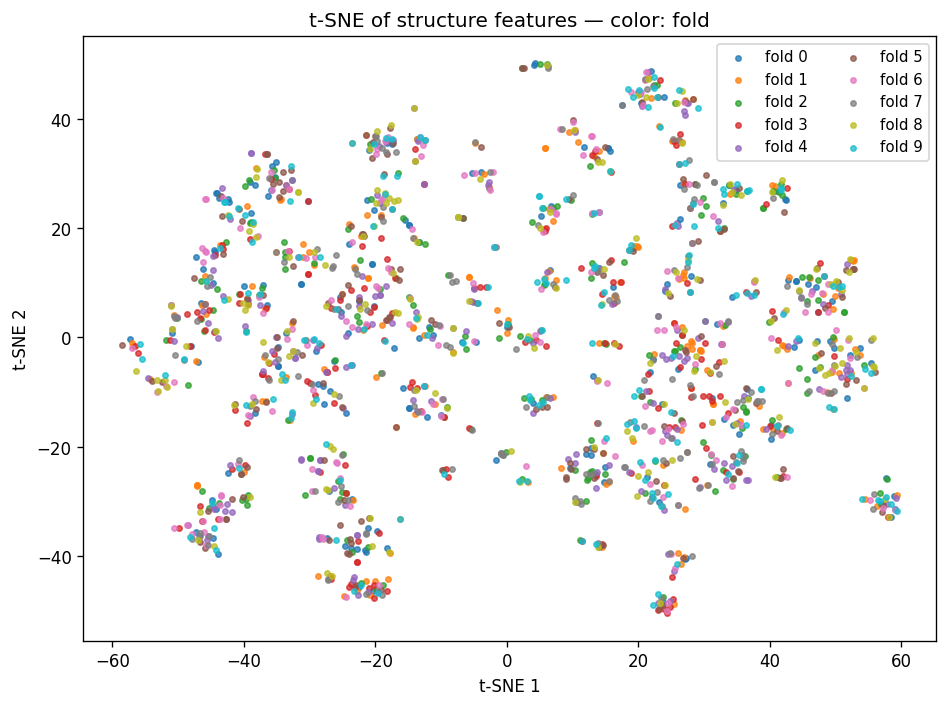

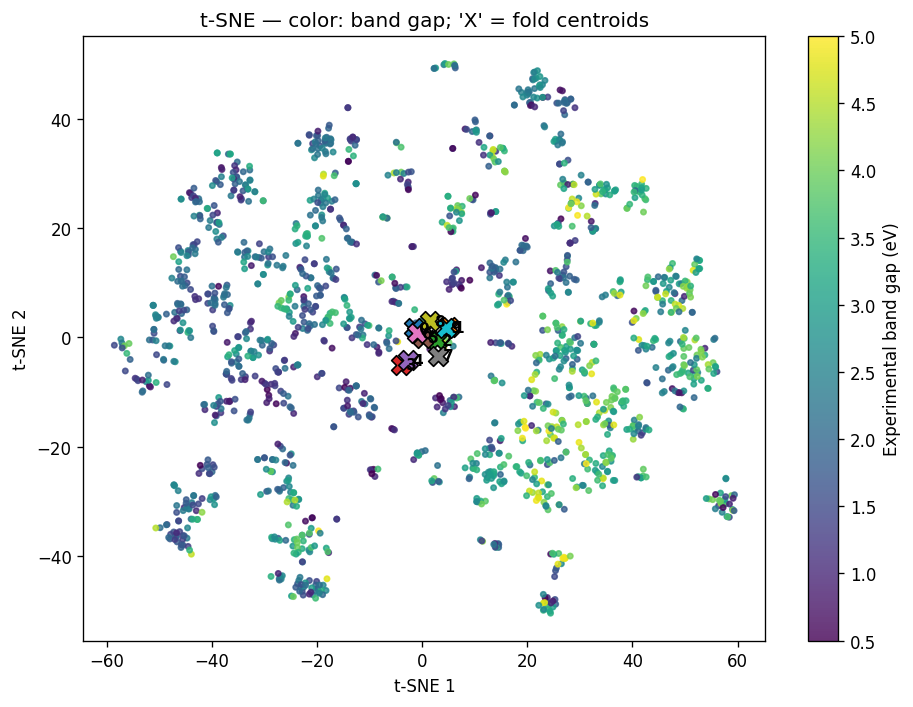

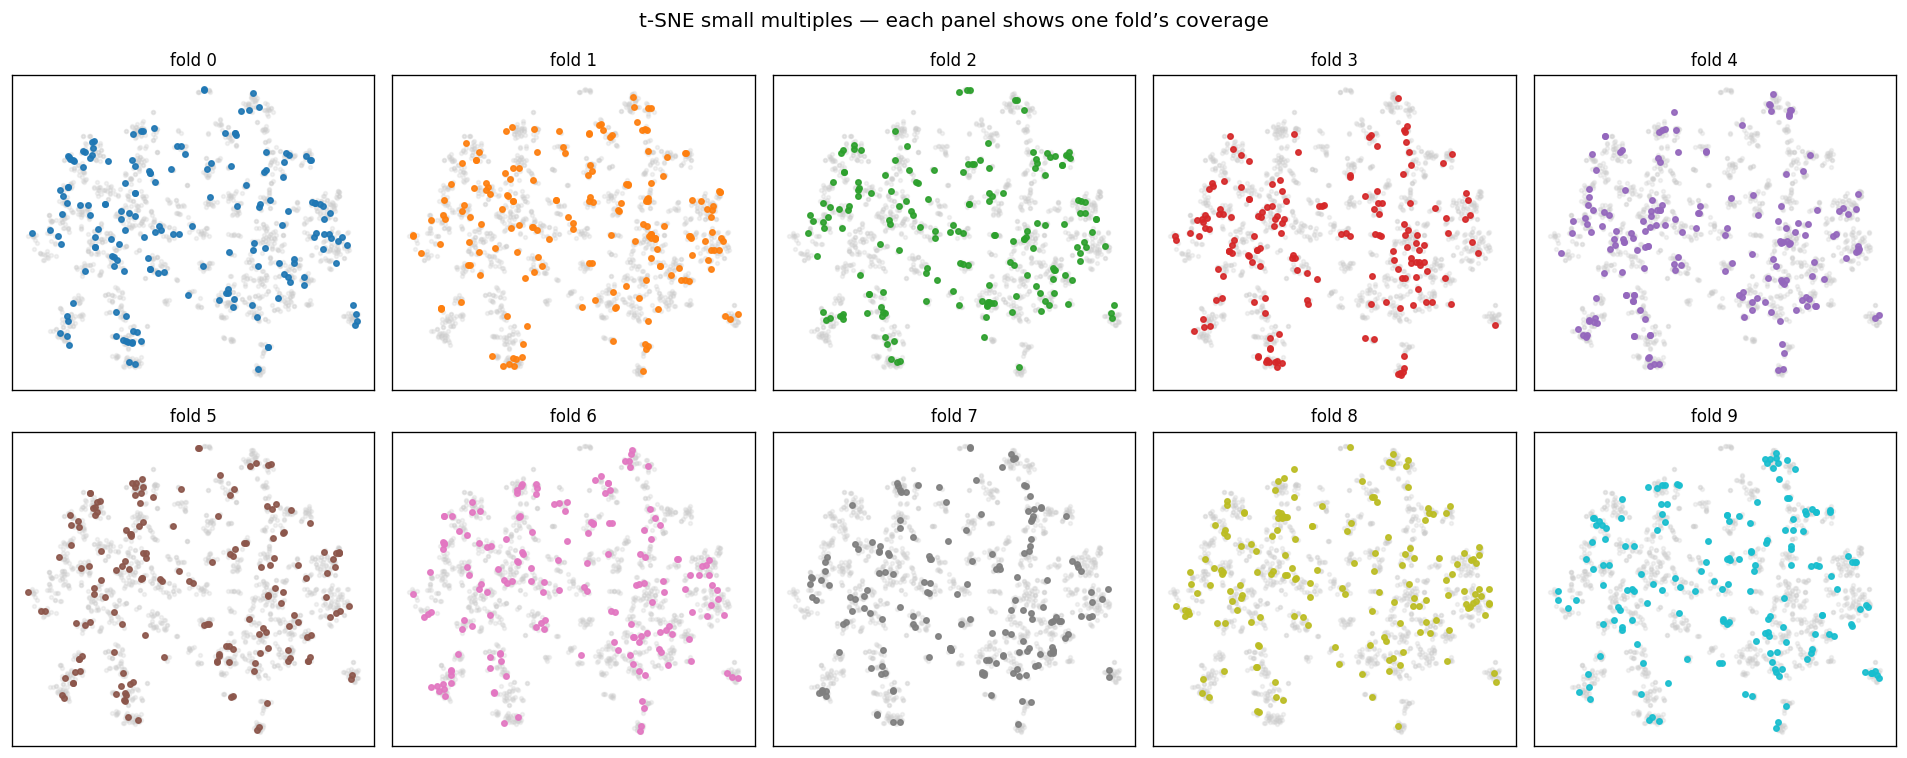

In [ ]:
# -*- coding: utf-8 -*-
"""
t-SNE embedding of structure-driven features (no element encoding).
Reads 10 sgnum CSVs, extracts features via your CIFData+extract_features,
then runs PCA(50) -> t-SNE(2D). Produces two PDFs.

Requires: pandas, numpy, scikit-learn, matplotlib, your data_process package.
"""

import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# Config
# -----------------------------
CSV_GLOB = "data/split/composition_split/mf.composition.k*_outer.test.csv"
CIF_FOLDER = "cif_file_filtered"
ATOM_INIT_JSON = "encoding/atom_init.json"   # set to None if not needed by CIFData
RANDOM_STATE = 2024
PCA_TO_50 = True          # speed/stability trick: reduce to 50 dims before t-SNE
TSNE_PERPLEXITY = 30.0    # try {20, 30, 40} if you want
TSNE_N_ITER = 2000
TSNE_LEARNING_RATE = "auto"

os.makedirs("figs", exist_ok=True)

# -----------------------------
# Load sgnum folds
# -----------------------------
def get_fold_id(path):
    m = re.search(r"\.k(\d+)_outer\.test\.csv$", path)
    return int(m.group(1)) if m else None

paths = sorted(glob.glob(CSV_GLOB))
if len(paths) != 10:
    warnings.warn(f"Expected 10 CSVs, found {len(paths)}")

dfs = []
for p in paths:
    k = get_fold_id(p)
    df = pd.read_csv(p)
    if "bg_exp" not in df.columns:
        raise ValueError(f"'bg_exp' not found in {p}")
    df["fold"] = k
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["bg_exp"]).drop_duplicates(subset=["mpids","fold"]).reset_index(drop=True)

# -----------------------------
# Build dataset & extract features (your code)
# -----------------------------
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features

mpids_bg = df_all[["mpids", "bg_exp"]].rename(columns={"bg_exp": "band_gap"})

if ATOM_INIT_JSON is not None:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      init_file=ATOM_INIT_JSON, max_nbrs=14, radius=7.0, randomize=False)
else:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      max_nbrs=14, radius=7.0, randomize=False)

X, y = extract_features(dataset)  # X:(N,d) structural features; y:(N,) band gap
folds = df_all["fold"].values
mpids = df_all["mpids"].values

if X.shape[0] != len(folds):
    warnings.warn("Feature rows != CSV rows; assuming CIFData kept order and trimming to min length.")
    n = min(X.shape[0], len(folds))
    X, y, folds, mpids = X[:n], y[:n], folds[:n], mpids[:n]

# -----------------------------
# Standardize -> (optional) PCA -> t-SNE
# -----------------------------
X_std = StandardScaler().fit_transform(X)

if PCA_TO_50 and X_std.shape[1] > 50:
    pca50 = PCA(n_components=50, random_state=RANDOM_STATE)
    X_tsne_in = pca50.fit_transform(X_std)
else:
    X_tsne_in = X_std

tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    learning_rate=TSNE_LEARNING_RATE,
    n_iter=TSNE_N_ITER,
    init="pca",
    random_state=RANDOM_STATE,
    metric="euclidean",
    verbose=1
)
Z = tsne.fit_transform(X_tsne_in)  # (N,2)

# -----------------------------
# Plots
# -----------------------------
import matplotlib as mpl
uniq_folds = sorted(np.unique(folds))
cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))
fold_color = {k: cmap_cat(i % cmap_cat.N) for i, k in enumerate(uniq_folds)}

# (A) color by fold
plt.figure(figsize=(8,6))
for k in uniq_folds:
    idx = (folds == k)
    plt.scatter(Z[idx,0], Z[idx,1], s=10, alpha=0.75, color=fold_color[k], label=f"fold {k}")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.title("t-SNE of structure features — color: fold")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_fold.pdf", bbox_inches="tight")
plt.show()

# (B) color by band gap + fold centroids
plt.figure(figsize=(8,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=10, alpha=0.8, cmap="viridis")
cbar = plt.colorbar(sc); cbar.set_label("Experimental band gap (eV)")
for k in uniq_folds:
    idx = (folds == k)
    if np.sum(idx) == 0: continue
    cx, cy = Z[idx,0].mean(), Z[idx,1].mean()
    plt.scatter([cx],[cy], marker="X", s=140, edgecolor="k", linewidths=1.0, color=fold_color[k])
    plt.text(cx, cy, f" {k}", va="center", fontsize=9, weight="bold")
plt.title("t-SNE — color: band gap; 'X' = fold centroids")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_bg.pdf", bbox_inches="tight")
plt.show()

# (C) optional: small multiples
n = len(uniq_folds)
cols = min(5, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows), squeeze=False)
for ax, k in zip(axes.ravel(), uniq_folds):
    idx = (folds == k)
    ax.scatter(Z[:,0], Z[:,1], s=5, color=(0.8,0.8,0.8,0.25))
    ax.scatter(Z[idx,0], Z[idx,1], s=10, color=fold_color[k], alpha=0.9)
    ax.set_title(f"fold {k}", fontsize=10); ax.set_xticks([]); ax.set_yticks([])
for ax in axes.ravel()[len(uniq_folds):]:
    ax.axis("off")
fig.suptitle("t-SNE small multiples — each panel shows one fold’s coverage", y=0.98)
plt.tight_layout()
fig.savefig("figs/tsne_struct_small_multiples.pdf", bbox_inches="tight")
plt.show()


/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/struc

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1705 samples in 0.000s...
[t-SNE] Computed neighbors for 1705 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1705
[t-SNE] Computed conditional probabilities for sample 1705 / 1705
[t-SNE] Mean sigma: 4.499864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.890060
[t-SNE] KL divergence after 2000 iterations: 0.847024


/tmp/ipykernel_324558/249491062.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))


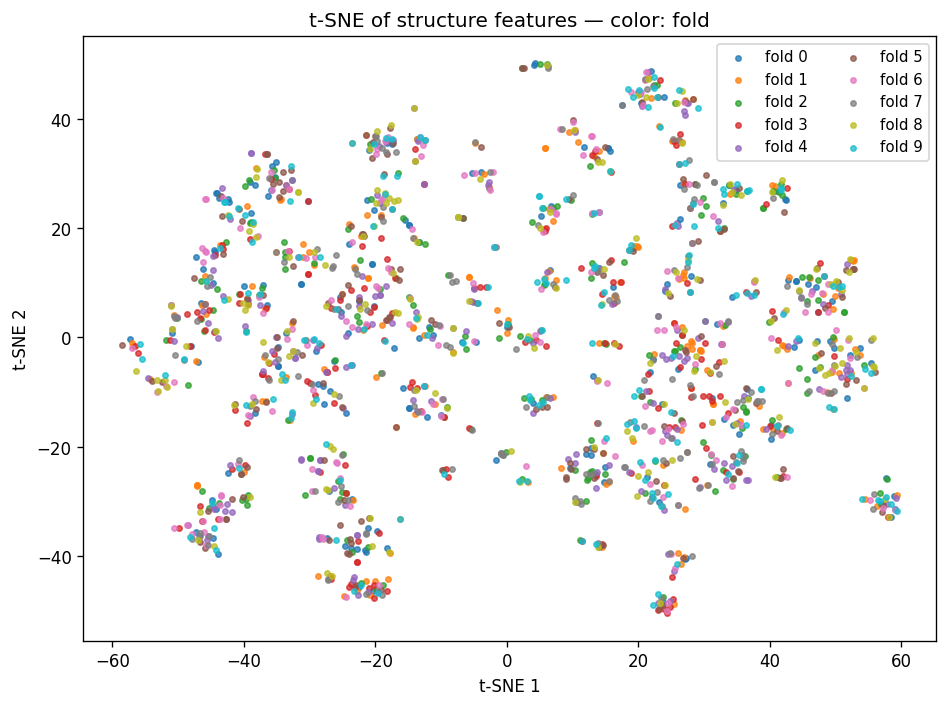

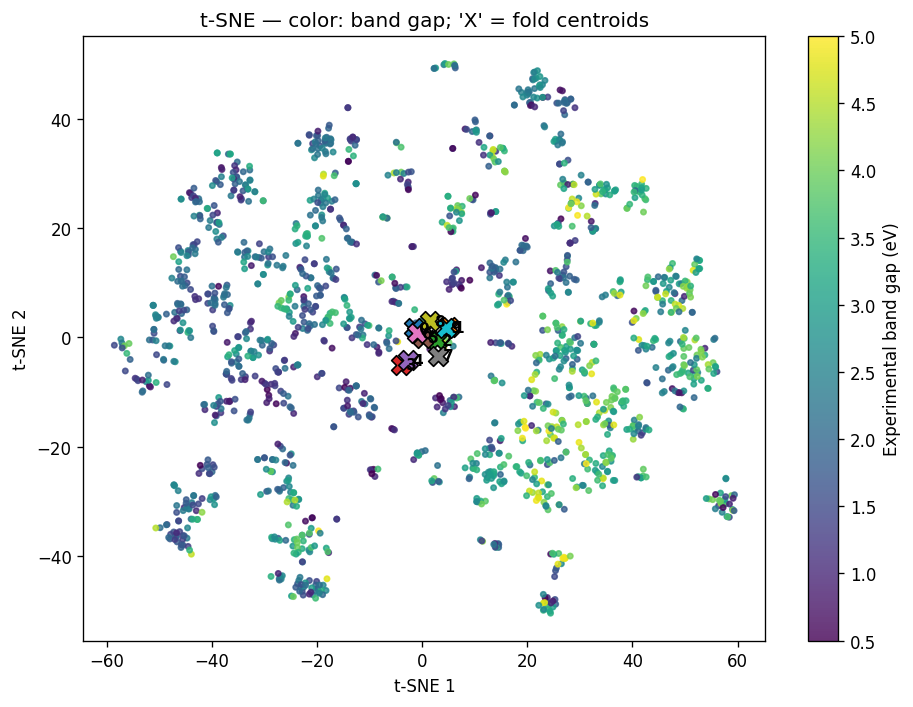

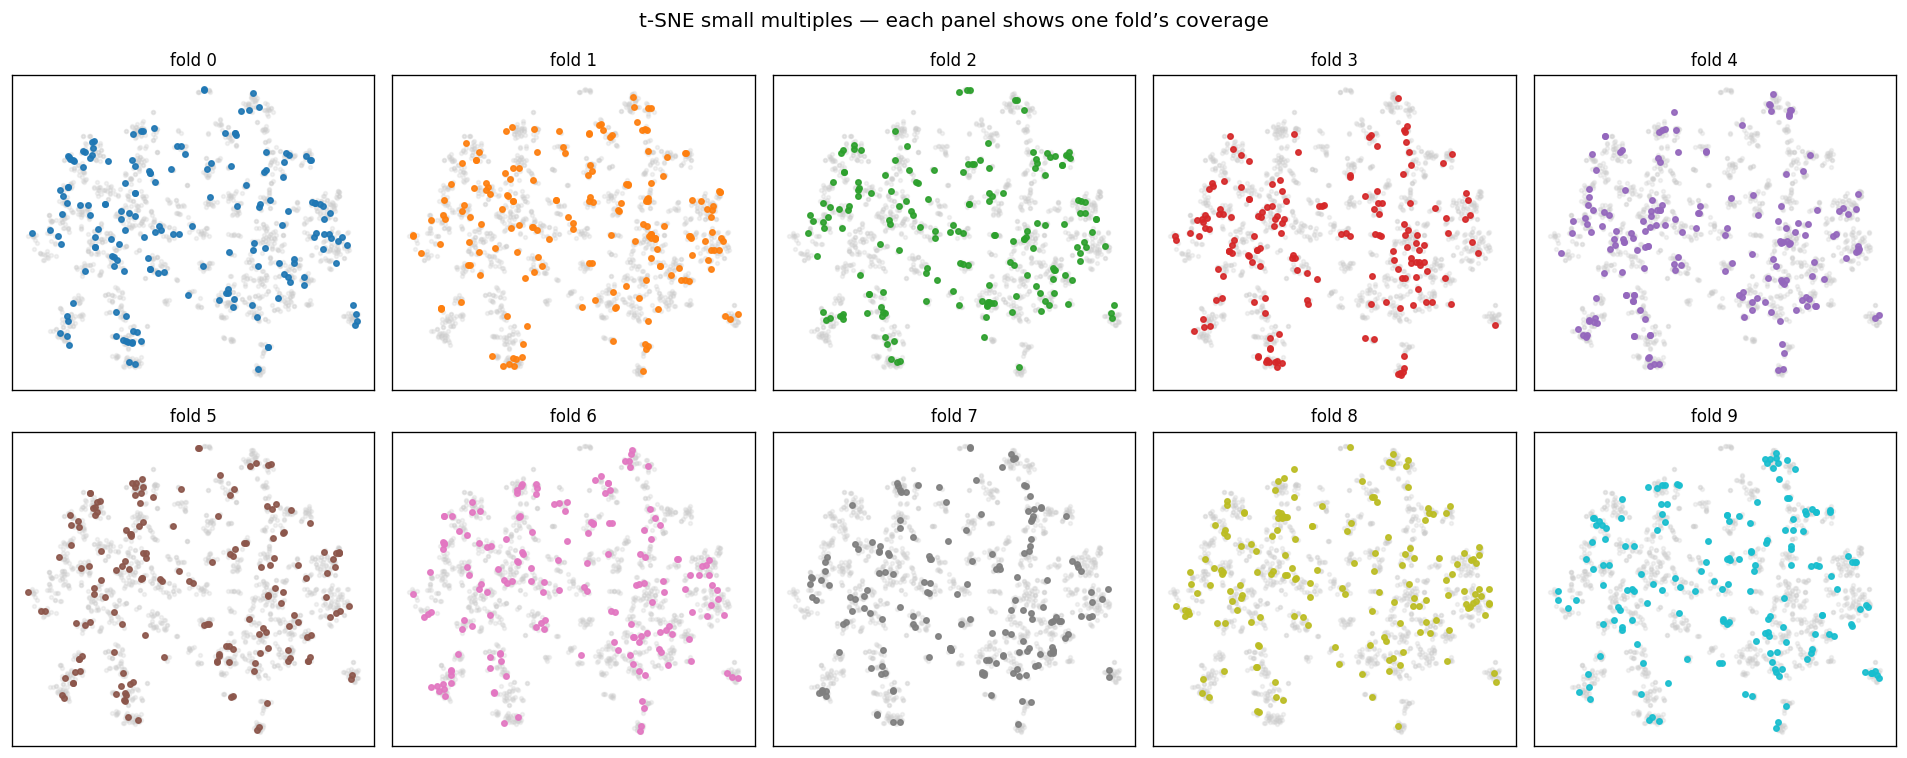

In [ ]:
# -*- coding: utf-8 -*-
"""
t-SNE embedding of structure-driven features (no element encoding).
Reads 10 sgnum CSVs, extracts features via your CIFData+extract_features,
then runs PCA(50) -> t-SNE(2D). Produces two PDFs.

Requires: pandas, numpy, scikit-learn, matplotlib, your data_process package.
"""

import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# Config
# -----------------------------
CSV_GLOB = "data/split/composition_split/mf.composition.k*_outer.test.csv"
CIF_FOLDER = "cif_file_filtered"
ATOM_INIT_JSON = "encoding/atom_init.json"   # set to None if not needed by CIFData
RANDOM_STATE = 2024
PCA_TO_50 = True          # speed/stability trick: reduce to 50 dims before t-SNE
TSNE_PERPLEXITY = 30.0    # try {20, 30, 40} if you want
TSNE_N_ITER = 2000
TSNE_LEARNING_RATE = "auto"

os.makedirs("figs", exist_ok=True)

# -----------------------------
# Load sgnum folds
# -----------------------------
def get_fold_id(path):
    m = re.search(r"\.k(\d+)_outer\.test\.csv$", path)
    return int(m.group(1)) if m else None

paths = sorted(glob.glob(CSV_GLOB))
if len(paths) != 10:
    warnings.warn(f"Expected 10 CSVs, found {len(paths)}")

dfs = []
for p in paths:
    k = get_fold_id(p)
    df = pd.read_csv(p)
    if "bg_exp" not in df.columns:
        raise ValueError(f"'bg_exp' not found in {p}")
    df["fold"] = k
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["bg_exp"]).drop_duplicates(subset=["mpids","fold"]).reset_index(drop=True)

# -----------------------------
# Build dataset & extract features (your code)
# -----------------------------
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features

mpids_bg = df_all[["mpids", "bg_exp"]].rename(columns={"bg_exp": "band_gap"})

if ATOM_INIT_JSON is not None:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      init_file=ATOM_INIT_JSON, max_nbrs=14, radius=7.0, randomize=False)
else:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      max_nbrs=14, radius=7.0, randomize=False)

X, y = extract_features(dataset)  # X:(N,d) structural features; y:(N,) band gap
folds = df_all["fold"].values
mpids = df_all["mpids"].values

if X.shape[0] != len(folds):
    warnings.warn("Feature rows != CSV rows; assuming CIFData kept order and trimming to min length.")
    n = min(X.shape[0], len(folds))
    X, y, folds, mpids = X[:n], y[:n], folds[:n], mpids[:n]

# -----------------------------
# Standardize -> (optional) PCA -> t-SNE
# -----------------------------
X_std = StandardScaler().fit_transform(X)

if PCA_TO_50 and X_std.shape[1] > 50:
    pca50 = PCA(n_components=50, random_state=RANDOM_STATE)
    X_tsne_in = pca50.fit_transform(X_std)
else:
    X_tsne_in = X_std

tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    learning_rate=TSNE_LEARNING_RATE,
    n_iter=TSNE_N_ITER,
    init="pca",
    random_state=RANDOM_STATE,
    metric="euclidean",
    verbose=1
)
Z = tsne.fit_transform(X_tsne_in)  # (N,2)

# -----------------------------
# Plots
# -----------------------------
import matplotlib as mpl
uniq_folds = sorted(np.unique(folds))
cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))
fold_color = {k: cmap_cat(i % cmap_cat.N) for i, k in enumerate(uniq_folds)}

# (A) color by fold
plt.figure(figsize=(8,6))
for k in uniq_folds:
    idx = (folds == k)
    plt.scatter(Z[idx,0], Z[idx,1], s=10, alpha=0.75, color=fold_color[k], label=f"fold {k}")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.title("t-SNE of structure features — color: fold")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_fold.pdf", bbox_inches="tight")
plt.show()

# (B) color by band gap + fold centroids
plt.figure(figsize=(8,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=10, alpha=0.8, cmap="viridis")
cbar = plt.colorbar(sc); cbar.set_label("Experimental band gap (eV)")
for k in uniq_folds:
    idx = (folds == k)
    if np.sum(idx) == 0: continue
    cx, cy = Z[idx,0].mean(), Z[idx,1].mean()
    plt.scatter([cx],[cy], marker="X", s=140, edgecolor="k", linewidths=1.0, color=fold_color[k])
    plt.text(cx, cy, f" {k}", va="center", fontsize=9, weight="bold")
plt.title("t-SNE — color: band gap; 'X' = fold centroids")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_bg.pdf", bbox_inches="tight")
plt.show()

# (C) optional: small multiples
n = len(uniq_folds)
cols = min(5, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows), squeeze=False)
for ax, k in zip(axes.ravel(), uniq_folds):
    idx = (folds == k)
    ax.scatter(Z[:,0], Z[:,1], s=5, color=(0.8,0.8,0.8,0.25))
    ax.scatter(Z[idx,0], Z[idx,1], s=10, color=fold_color[k], alpha=0.9)
    ax.set_title(f"fold {k}", fontsize=10); ax.set_xticks([]); ax.set_yticks([])
for ax in axes.ravel()[len(uniq_folds):]:
    ax.axis("off")
fig.suptitle("t-SNE small multiples — each panel shows one fold’s coverage", y=0.98)
plt.tight_layout()
fig.savefig("figs/tsne_struct_small_multiples.pdf", bbox_inches="tight")
plt.show()


/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/struc

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1705 samples in 0.000s...
[t-SNE] Computed neighbors for 1705 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1705
[t-SNE] Computed conditional probabilities for sample 1705 / 1705
[t-SNE] Mean sigma: 4.499864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.890060
[t-SNE] KL divergence after 2000 iterations: 0.847024


/tmp/ipykernel_324558/249491062.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))


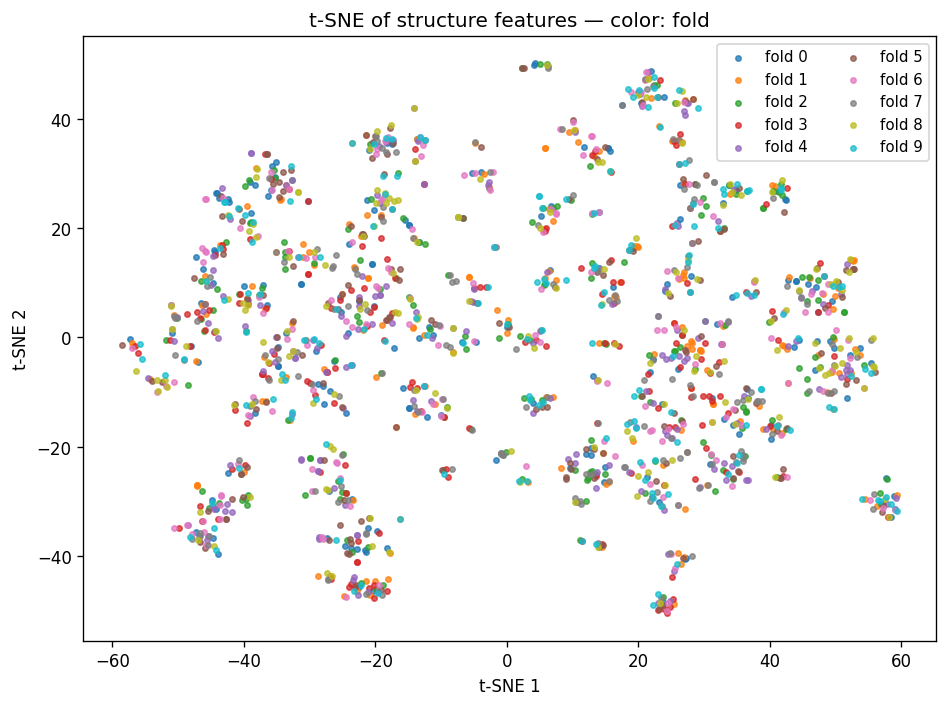

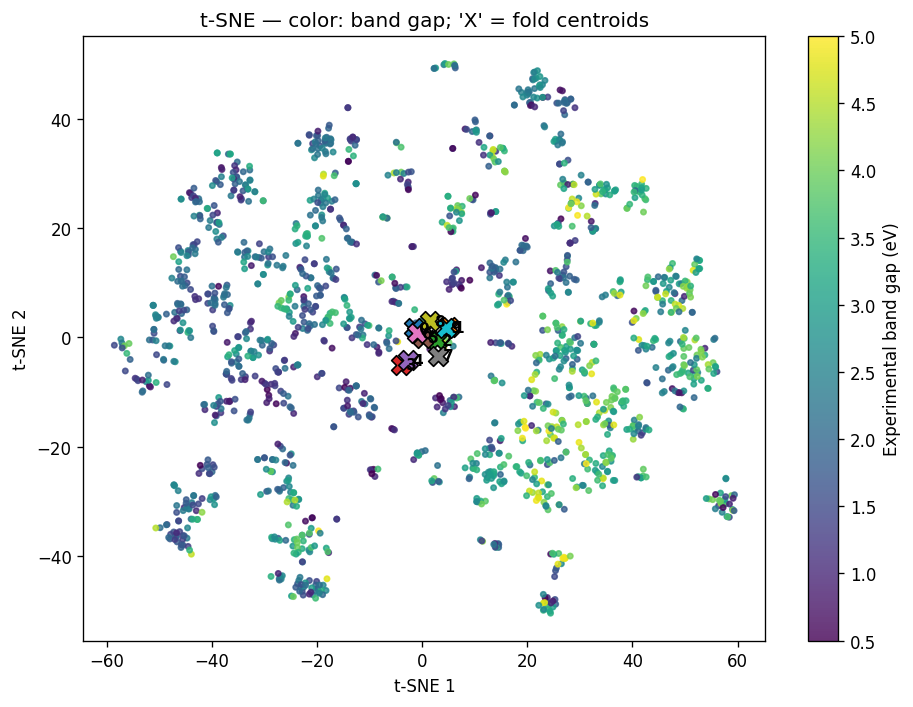

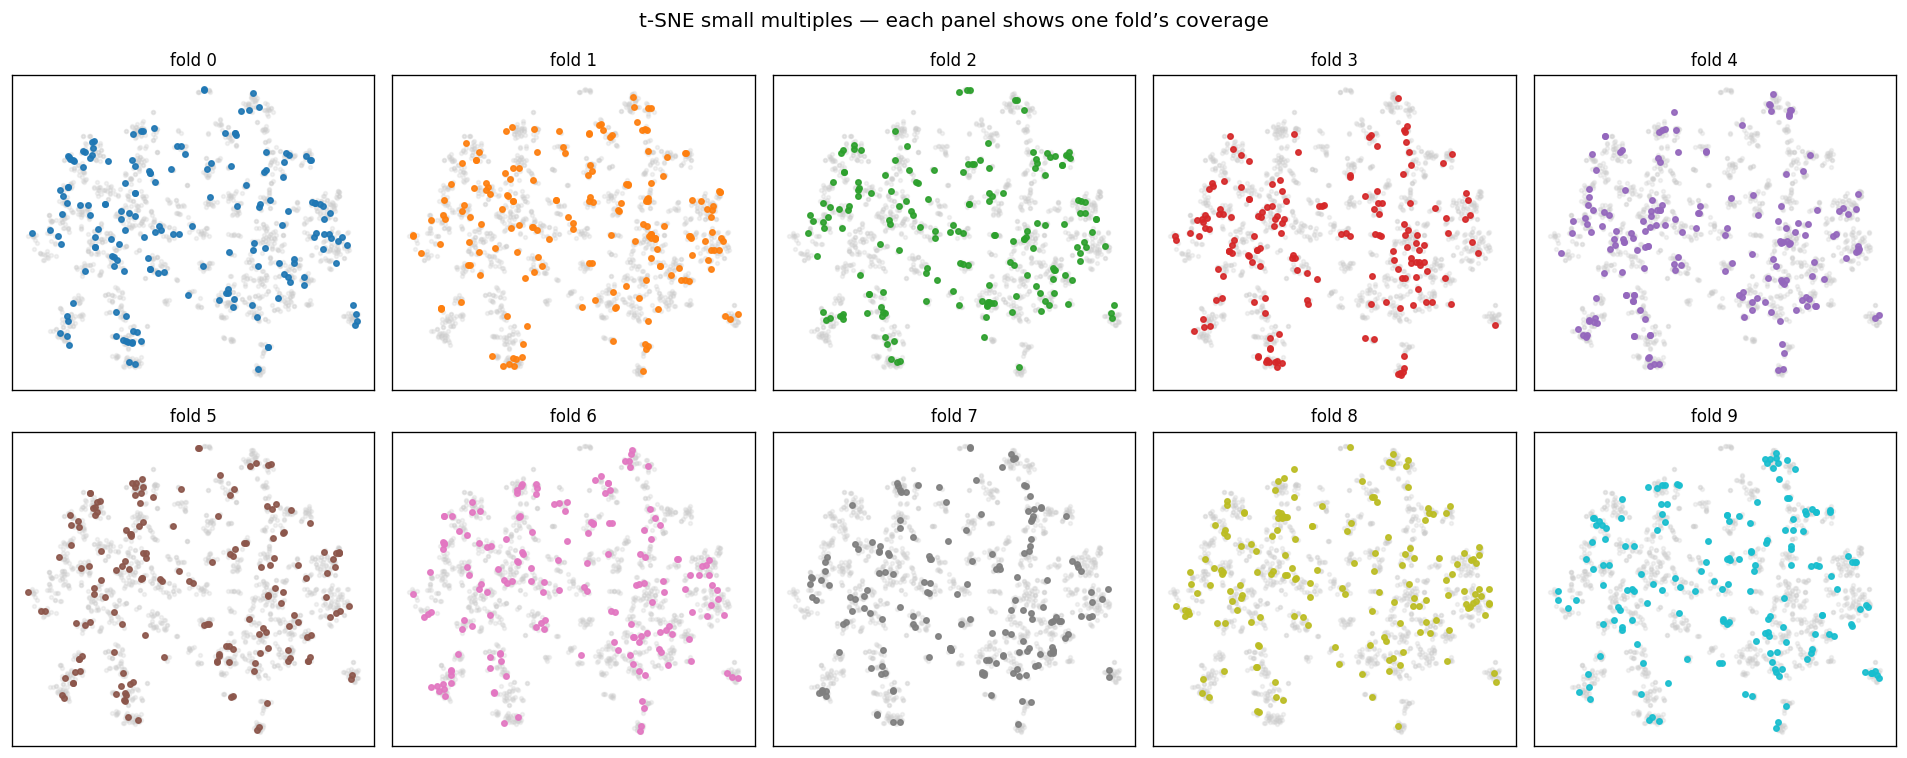

In [ ]:
# -*- coding: utf-8 -*-
"""
t-SNE embedding of structure-driven features (no element encoding).
Reads 10 sgnum CSVs, extracts features via your CIFData+extract_features,
then runs PCA(50) -> t-SNE(2D). Produces two PDFs.

Requires: pandas, numpy, scikit-learn, matplotlib, your data_process package.
"""

import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# Config
# -----------------------------
CSV_GLOB = "data/split/composition_split/mf.composition.k*_outer.test.csv"
CIF_FOLDER = "cif_file_filtered"
ATOM_INIT_JSON = "encoding/atom_init.json"   # set to None if not needed by CIFData
RANDOM_STATE = 2024
PCA_TO_50 = True          # speed/stability trick: reduce to 50 dims before t-SNE
TSNE_PERPLEXITY = 30.0    # try {20, 30, 40} if you want
TSNE_N_ITER = 2000
TSNE_LEARNING_RATE = "auto"

os.makedirs("figs", exist_ok=True)

# -----------------------------
# Load sgnum folds
# -----------------------------
def get_fold_id(path):
    m = re.search(r"\.k(\d+)_outer\.test\.csv$", path)
    return int(m.group(1)) if m else None

paths = sorted(glob.glob(CSV_GLOB))
if len(paths) != 10:
    warnings.warn(f"Expected 10 CSVs, found {len(paths)}")

dfs = []
for p in paths:
    k = get_fold_id(p)
    df = pd.read_csv(p)
    if "bg_exp" not in df.columns:
        raise ValueError(f"'bg_exp' not found in {p}")
    df["fold"] = k
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["bg_exp"]).drop_duplicates(subset=["mpids","fold"]).reset_index(drop=True)

# -----------------------------
# Build dataset & extract features (your code)
# -----------------------------
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features

mpids_bg = df_all[["mpids", "bg_exp"]].rename(columns={"bg_exp": "band_gap"})

if ATOM_INIT_JSON is not None:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      init_file=ATOM_INIT_JSON, max_nbrs=14, radius=7.0, randomize=False)
else:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      max_nbrs=14, radius=7.0, randomize=False)

X, y = extract_features(dataset)  # X:(N,d) structural features; y:(N,) band gap
folds = df_all["fold"].values
mpids = df_all["mpids"].values

if X.shape[0] != len(folds):
    warnings.warn("Feature rows != CSV rows; assuming CIFData kept order and trimming to min length.")
    n = min(X.shape[0], len(folds))
    X, y, folds, mpids = X[:n], y[:n], folds[:n], mpids[:n]

# -----------------------------
# Standardize -> (optional) PCA -> t-SNE
# -----------------------------
X_std = StandardScaler().fit_transform(X)

if PCA_TO_50 and X_std.shape[1] > 50:
    pca50 = PCA(n_components=50, random_state=RANDOM_STATE)
    X_tsne_in = pca50.fit_transform(X_std)
else:
    X_tsne_in = X_std

tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    learning_rate=TSNE_LEARNING_RATE,
    n_iter=TSNE_N_ITER,
    init="pca",
    random_state=RANDOM_STATE,
    metric="euclidean",
    verbose=1
)
Z = tsne.fit_transform(X_tsne_in)  # (N,2)

# -----------------------------
# Plots
# -----------------------------
import matplotlib as mpl
uniq_folds = sorted(np.unique(folds))
cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))
fold_color = {k: cmap_cat(i % cmap_cat.N) for i, k in enumerate(uniq_folds)}

# (A) color by fold
plt.figure(figsize=(8,6))
for k in uniq_folds:
    idx = (folds == k)
    plt.scatter(Z[idx,0], Z[idx,1], s=10, alpha=0.75, color=fold_color[k], label=f"fold {k}")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.title("t-SNE of structure features — color: fold")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_fold.pdf", bbox_inches="tight")
plt.show()

# (B) color by band gap + fold centroids
plt.figure(figsize=(8,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=10, alpha=0.8, cmap="viridis")
cbar = plt.colorbar(sc); cbar.set_label("Experimental band gap (eV)")
for k in uniq_folds:
    idx = (folds == k)
    if np.sum(idx) == 0: continue
    cx, cy = Z[idx,0].mean(), Z[idx,1].mean()
    plt.scatter([cx],[cy], marker="X", s=140, edgecolor="k", linewidths=1.0, color=fold_color[k])
    plt.text(cx, cy, f" {k}", va="center", fontsize=9, weight="bold")
plt.title("t-SNE — color: band gap; 'X' = fold centroids")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_bg.pdf", bbox_inches="tight")
plt.show()

# (C) optional: small multiples
n = len(uniq_folds)
cols = min(5, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows), squeeze=False)
for ax, k in zip(axes.ravel(), uniq_folds):
    idx = (folds == k)
    ax.scatter(Z[:,0], Z[:,1], s=5, color=(0.8,0.8,0.8,0.25))
    ax.scatter(Z[idx,0], Z[idx,1], s=10, color=fold_color[k], alpha=0.9)
    ax.set_title(f"fold {k}", fontsize=10); ax.set_xticks([]); ax.set_yticks([])
for ax in axes.ravel()[len(uniq_folds):]:
    ax.axis("off")
fig.suptitle("t-SNE small multiples — each panel shows one fold’s coverage", y=0.98)
plt.tight_layout()
fig.savefig("figs/tsne_struct_small_multiples.pdf", bbox_inches="tight")
plt.show()


/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/haolin/miniconda3/envs/MPdataexplore/lib/python3.10/site-packages/pymatgen/core/struc

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1705 samples in 0.000s...
[t-SNE] Computed neighbors for 1705 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1705
[t-SNE] Computed conditional probabilities for sample 1705 / 1705
[t-SNE] Mean sigma: 4.499864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.890060
[t-SNE] KL divergence after 2000 iterations: 0.847024


/tmp/ipykernel_324558/249491062.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))


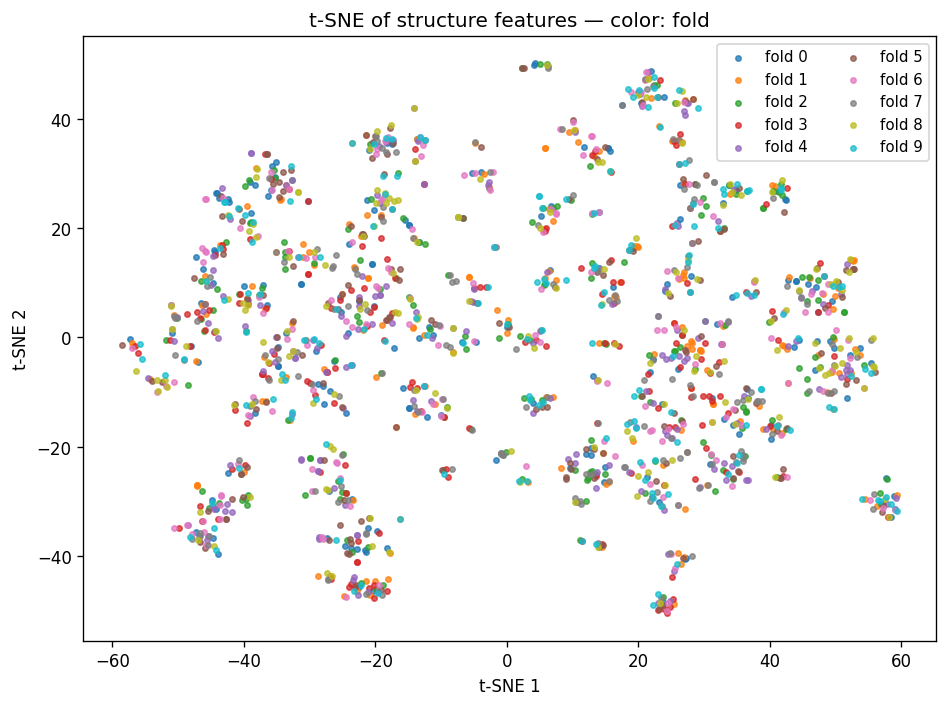

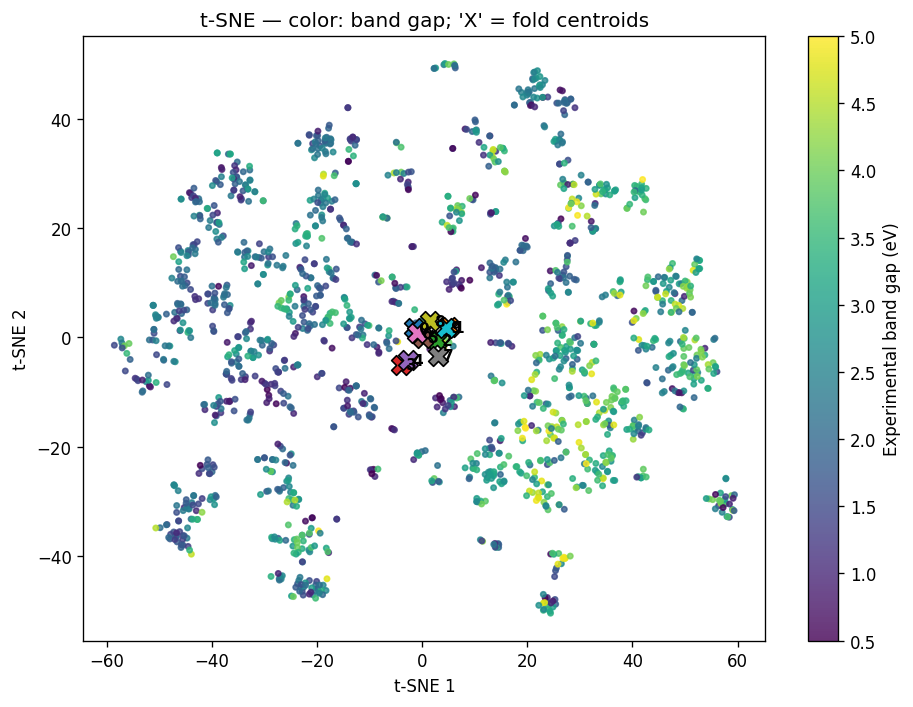

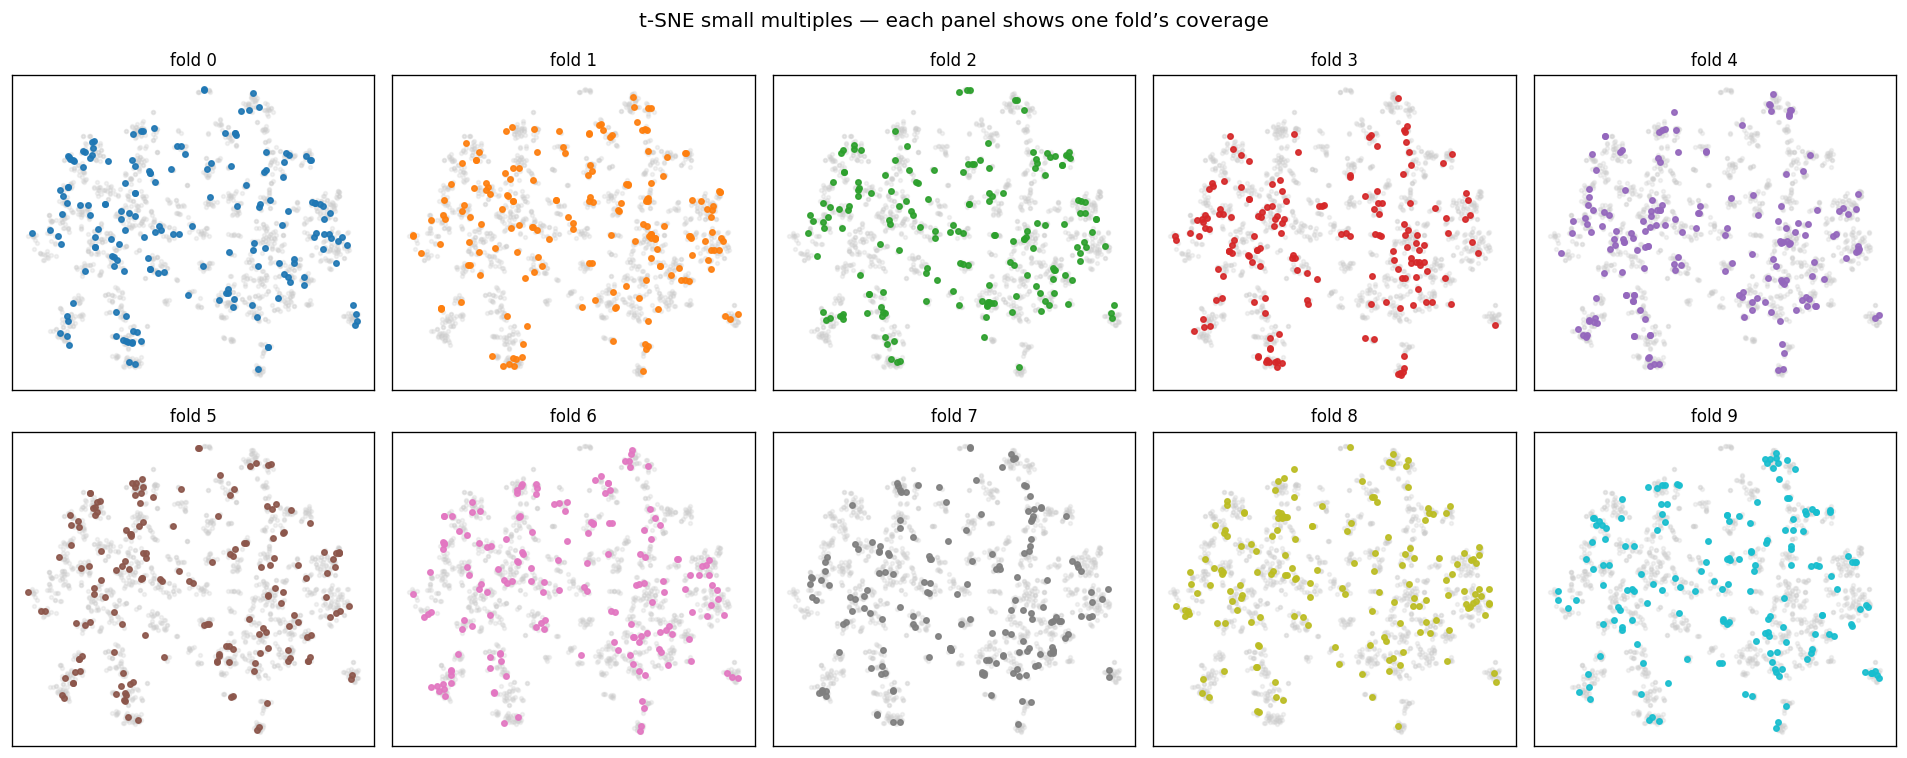

In [ ]:
# -*- coding: utf-8 -*-
"""
t-SNE embedding of structure-driven features (no element encoding).
Reads 10 sgnum CSVs, extracts features via your CIFData+extract_features,
then runs PCA(50) -> t-SNE(2D). Produces two PDFs.

Requires: pandas, numpy, scikit-learn, matplotlib, your data_process package.
"""

import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# Config
# -----------------------------
CSV_GLOB = "data/split/composition_split/mf.composition.k*_outer.test.csv"
CIF_FOLDER = "cif_file_filtered"
ATOM_INIT_JSON = "encoding/atom_init.json"   # set to None if not needed by CIFData
RANDOM_STATE = 2024
PCA_TO_50 = True          # speed/stability trick: reduce to 50 dims before t-SNE
TSNE_PERPLEXITY = 30.0    # try {20, 30, 40} if you want
TSNE_N_ITER = 2000
TSNE_LEARNING_RATE = "auto"

os.makedirs("figs", exist_ok=True)

# -----------------------------
# Load sgnum folds
# -----------------------------
def get_fold_id(path):
    m = re.search(r"\.k(\d+)_outer\.test\.csv$", path)
    return int(m.group(1)) if m else None

paths = sorted(glob.glob(CSV_GLOB))
if len(paths) != 10:
    warnings.warn(f"Expected 10 CSVs, found {len(paths)}")

dfs = []
for p in paths:
    k = get_fold_id(p)
    df = pd.read_csv(p)
    if "bg_exp" not in df.columns:
        raise ValueError(f"'bg_exp' not found in {p}")
    df["fold"] = k
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["bg_exp"]).drop_duplicates(subset=["mpids","fold"]).reset_index(drop=True)

# -----------------------------
# Build dataset & extract features (your code)
# -----------------------------
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features

mpids_bg = df_all[["mpids", "bg_exp"]].rename(columns={"bg_exp": "band_gap"})

if ATOM_INIT_JSON is not None:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      init_file=ATOM_INIT_JSON, max_nbrs=14, radius=7.0, randomize=False)
else:
    dataset = CIFData(mpids_bg=mpids_bg, cif_folder=CIF_FOLDER,
                      max_nbrs=14, radius=7.0, randomize=False)

X, y = extract_features(dataset)  # X:(N,d) structural features; y:(N,) band gap
folds = df_all["fold"].values
mpids = df_all["mpids"].values

if X.shape[0] != len(folds):
    warnings.warn("Feature rows != CSV rows; assuming CIFData kept order and trimming to min length.")
    n = min(X.shape[0], len(folds))
    X, y, folds, mpids = X[:n], y[:n], folds[:n], mpids[:n]

# -----------------------------
# Standardize -> (optional) PCA -> t-SNE
# -----------------------------
X_std = StandardScaler().fit_transform(X)

if PCA_TO_50 and X_std.shape[1] > 50:
    pca50 = PCA(n_components=50, random_state=RANDOM_STATE)
    X_tsne_in = pca50.fit_transform(X_std)
else:
    X_tsne_in = X_std

tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    learning_rate=TSNE_LEARNING_RATE,
    n_iter=TSNE_N_ITER,
    init="pca",
    random_state=RANDOM_STATE,
    metric="euclidean",
    verbose=1
)
Z = tsne.fit_transform(X_tsne_in)  # (N,2)

# -----------------------------
# Plots
# -----------------------------
import matplotlib as mpl
uniq_folds = sorted(np.unique(folds))
cmap_cat = mpl.cm.get_cmap('tab10', max(10, len(uniq_folds)))
fold_color = {k: cmap_cat(i % cmap_cat.N) for i, k in enumerate(uniq_folds)}

# (A) color by fold
plt.figure(figsize=(8,6))
for k in uniq_folds:
    idx = (folds == k)
    plt.scatter(Z[idx,0], Z[idx,1], s=10, alpha=0.75, color=fold_color[k], label=f"fold {k}")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.title("t-SNE of structure features — color: fold")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_fold.pdf", bbox_inches="tight")
plt.show()

# (B) color by band gap + fold centroids
plt.figure(figsize=(8,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=10, alpha=0.8, cmap="viridis")
cbar = plt.colorbar(sc); cbar.set_label("Experimental band gap (eV)")
for k in uniq_folds:
    idx = (folds == k)
    if np.sum(idx) == 0: continue
    cx, cy = Z[idx,0].mean(), Z[idx,1].mean()
    plt.scatter([cx],[cy], marker="X", s=140, edgecolor="k", linewidths=1.0, color=fold_color[k])
    plt.text(cx, cy, f" {k}", va="center", fontsize=9, weight="bold")
plt.title("t-SNE — color: band gap; 'X' = fold centroids")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("figs/tsne_struct_by_bg.pdf", bbox_inches="tight")
plt.show()

# (C) optional: small multiples
n = len(uniq_folds)
cols = min(5, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows), squeeze=False)
for ax, k in zip(axes.ravel(), uniq_folds):
    idx = (folds == k)
    ax.scatter(Z[:,0], Z[:,1], s=5, color=(0.8,0.8,0.8,0.25))
    ax.scatter(Z[idx,0], Z[idx,1], s=10, color=fold_color[k], alpha=0.9)
    ax.set_title(f"fold {k}", fontsize=10); ax.set_xticks([]); ax.set_yticks([])
for ax in axes.ravel()[len(uniq_folds):]:
    ax.axis("off")
fig.suptitle("t-SNE small multiples — each panel shows one fold’s coverage", y=0.98)
plt.tight_layout()
fig.savefig("figs/tsne_struct_small_multiples.pdf", bbox_inches="tight")
plt.show()


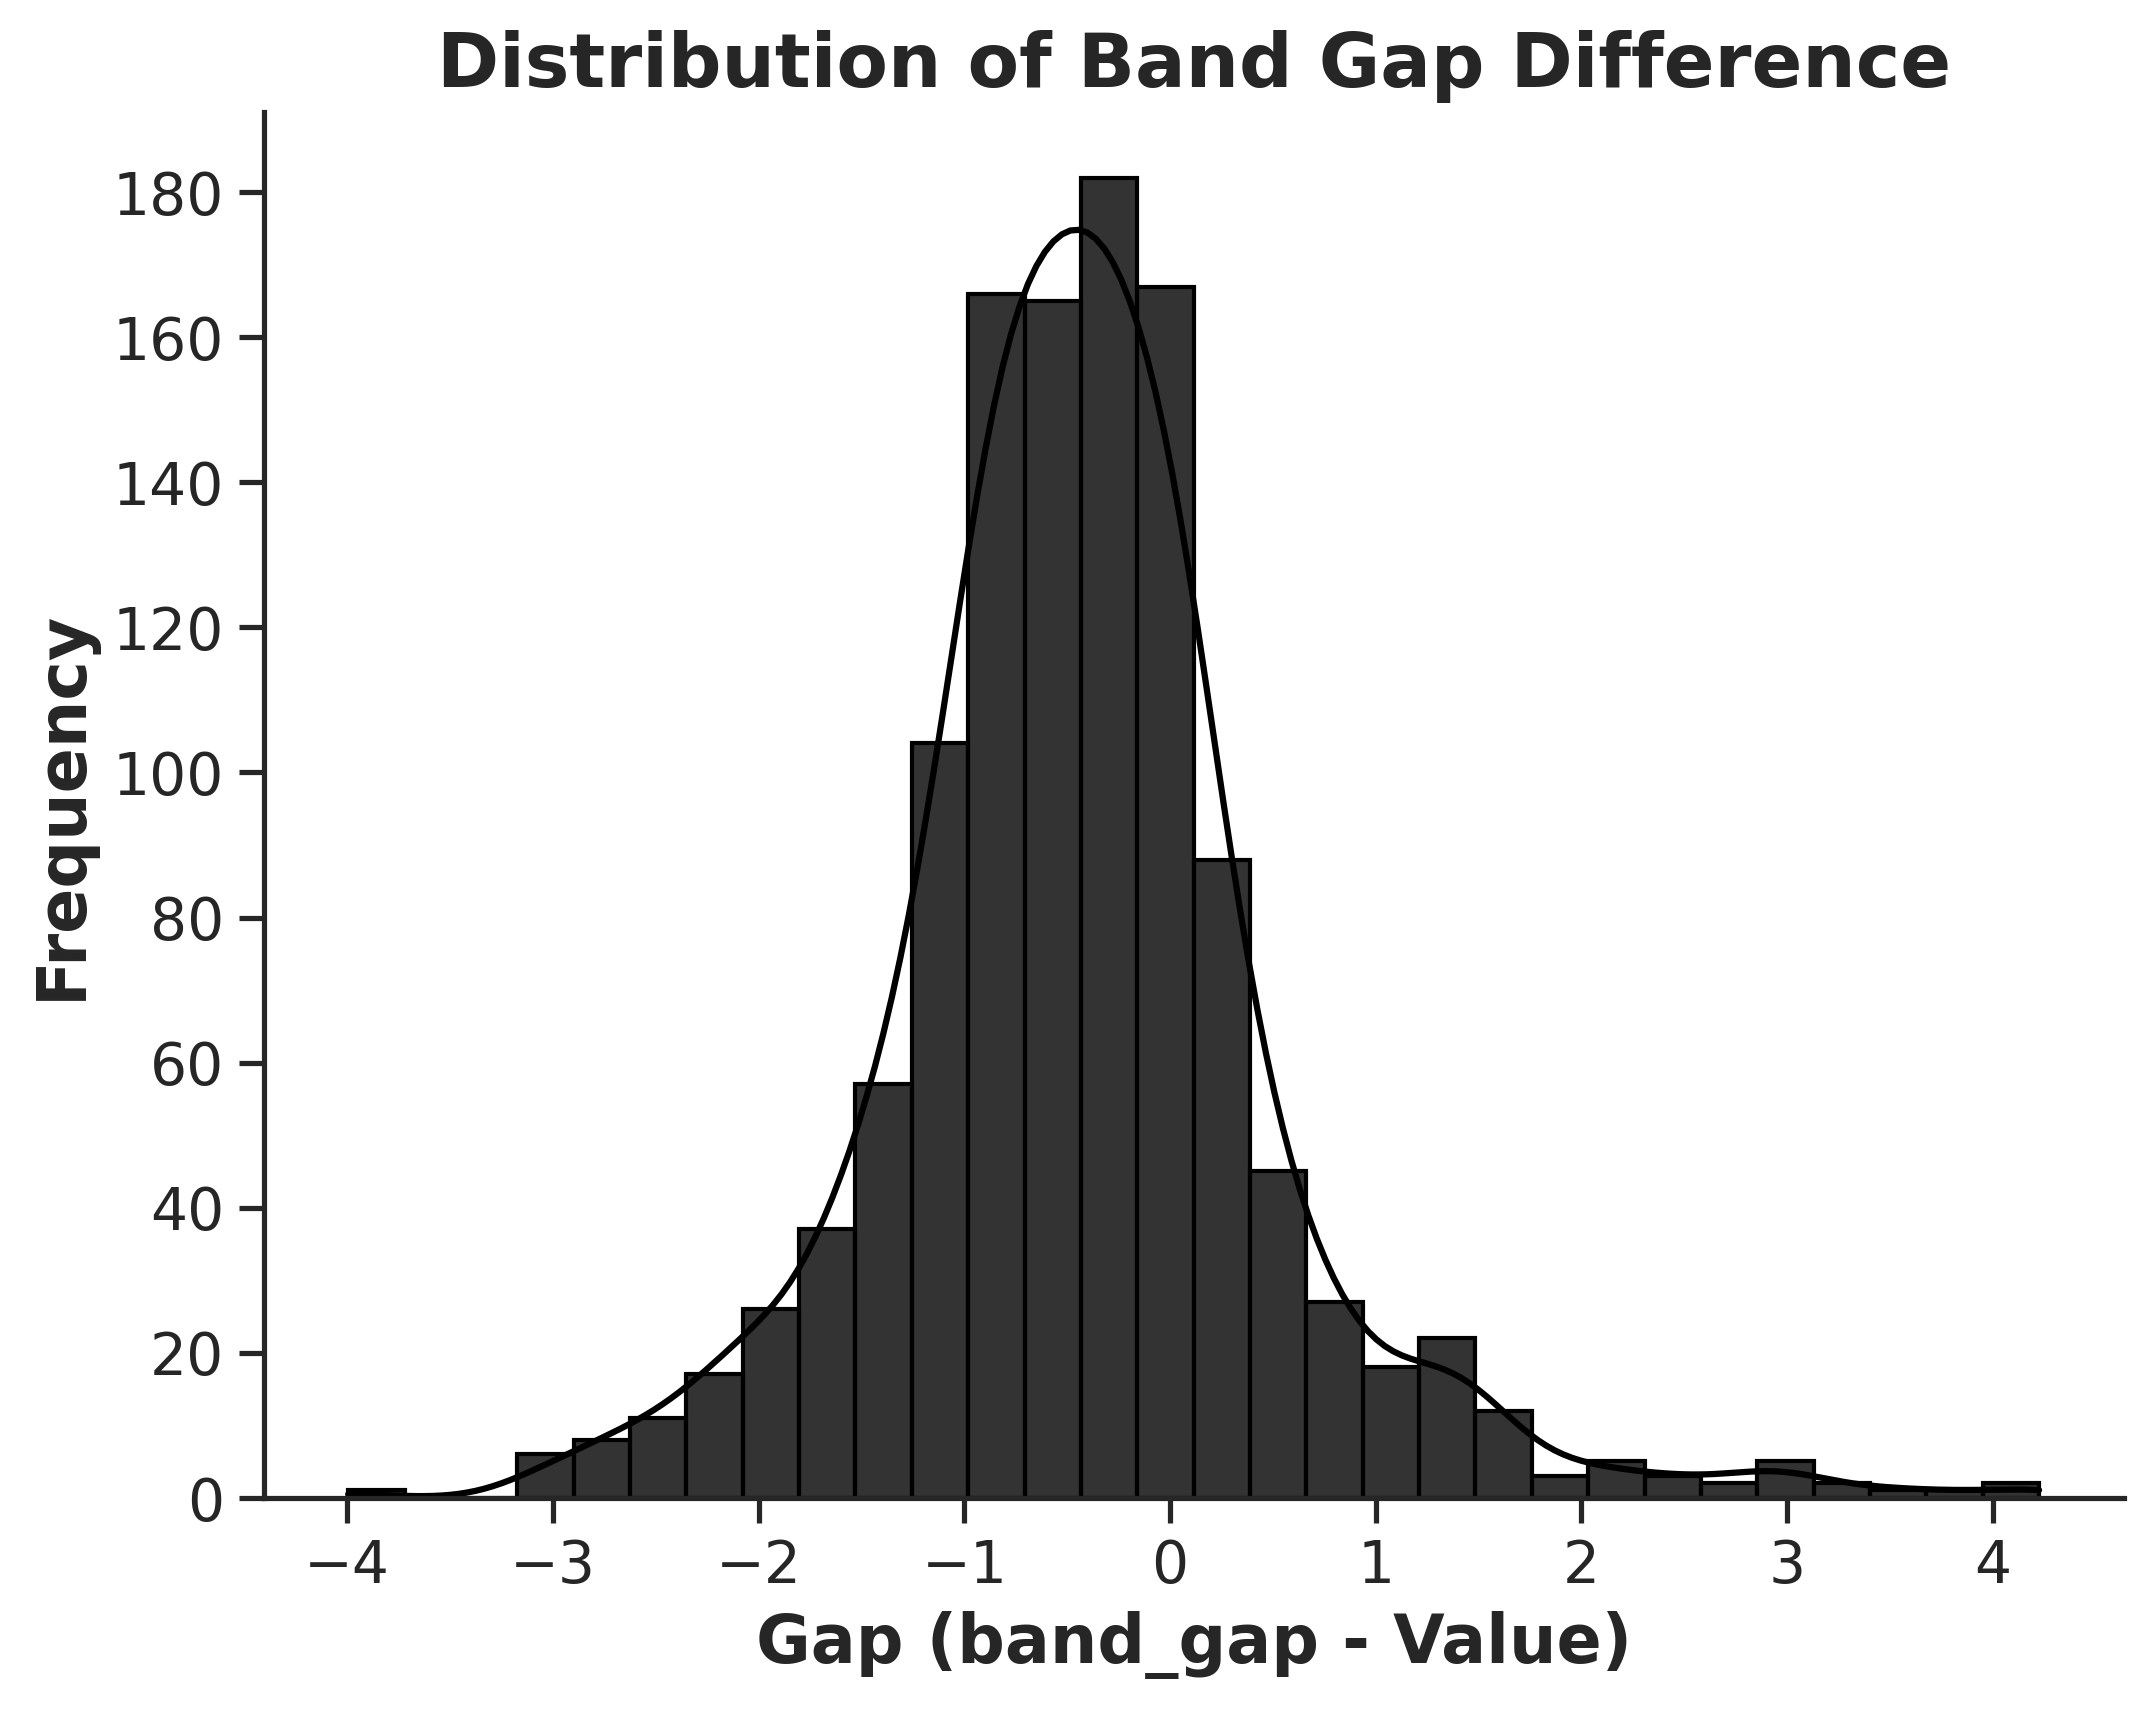

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Compute the gap (difference) between band_gap and Value
data["gap"] = data["band_gap"] - data["Value"]

# Set Nature-style aesthetics
sns.set_theme(style="ticks", font_scale=1.5)  # Clean theme with large font

# Create a high-quality histogram
plt.figure(figsize=(8, 6), dpi=300)  # High DPI for publication quality
sns.histplot(data["gap"], bins=30, kde=True, color="black", edgecolor="black", alpha=0.8)

# Formatting
plt.xlabel("Gap (band_gap - Value)", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.title("Distribution of Band Gap Difference", fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Adjust tick format
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Save as high-quality image (optional)
# plt.savefig("band_gap_histogram.png", dpi=300, bbox_inches="tight")

plt.show()




In [ ]:
unique_data

formula      mpids  is_stable  theoretical  band_gap  \
0       Ag2CO3  mp-560717      False        False    0.7490   
1     Ag2Mo2O7   mp-27966       True        False    1.9011   
2      Ag2MoO4   mp-19318      False        False    1.8731   
3         Ag2S  mp-556225      False         True    1.0853   
7       Ag2WO4  mp-504466      False         True    2.0439   
...        ...        ...        ...          ...       ...   
1344     Zr3N4     mp-277       True        False    0.9705   
1346      ZrO2    mp-2858       True        False    3.5322   
1347      ZrS2    mp-1186       True        False    1.0418   
1348      ZrS3    mp-9921       True        False    1.1133   
1350    ZrTiO4  mp-753891      False         True    2.8427   

      formation_energy_per_atom  Value                          DOI  \
0                     -1.063132  2.300    10.1016/j.cej.2019.123192   
1                     -1.507471  2.685           10.1039/c5ta02337h   
2                     -1.251053  3.260  10.1016/j.physb.2019.02.036   
3                     -0.118033  1.090   10.1016/j.jece.2017.11.071   
7                     -1.348470  2.925    10.1016/j.cej.2019.05.060   
...                         ...    ...                          ...   
1344                  -1.852383  1.600    10.1016/j.tsf.2006.03.020   
1346                  -3.813618  5.000    10.1016/j.cej.2011.10.085   
1347                  -1.847667  1.700   10.1016/j.rinp.2018.10.028   
1348                  -1.574012  2.070           10.1039/c5cp02813b   
1350                  -3.613996  3.500           10.1039/c0jm00675k   

      compound_type  Category_count  
0            Oxides               1  
1            Oxides               1  
2            Oxides               1  
3     Chalcogenides               1  
7            Oxides               1  
...             ...             ...  
1344       Nitrides               1  
1346         Oxides               1  
1347  Chalcogenides               1  
1348  Chalcogenides               1  
1350         Oxides               1  

[904 rows x 10 columns]

/tmp/ipykernel_437007/4121684785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data["gap"] = unique_data["band_gap"] - unique_data["Value"]
/tmp/ipykernel_437007/4121684785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=unique_data, x="compound_type", y="Value", palette=fixed_palette, order=sorted_categories)


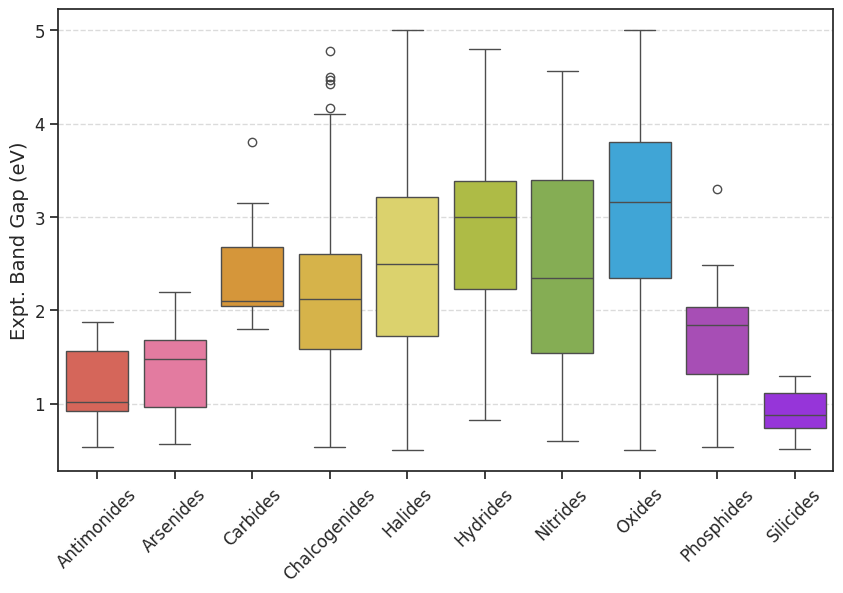

/tmp/ipykernel_437007/4121684785.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=unique_data, x="compound_type", y="gap", palette=fixed_palette, inner="quartile", order=sorted_categories)


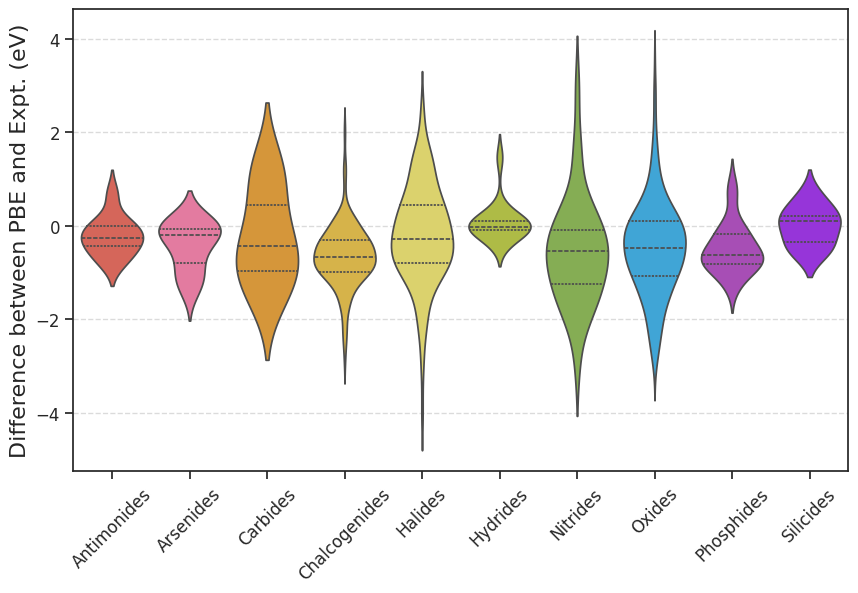

ANOVA Test Results:
F-statistic = 3.510, p-value = 2.769e-04
Significant difference found between compound types (p < 0.05)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Add a color for "Others" at the end of the palette
fixed_palette["Others"] = "#d7e1ee"  # Gray for "Others"

# Compute the gap (difference) between band_gap and Value
unique_data["gap"] = unique_data["band_gap"] - unique_data["Value"]

# Get a sorted list of compound types for alphabetical ordering
sorted_categories = sorted(unique_data["compound_type"].unique())

# Box Plot to compare gap distribution by category (alphabetical order)
plt.figure(figsize=(10, 6))
sns.boxplot(data=unique_data, x="compound_type", y="Value", palette=fixed_palette, order=sorted_categories)
plt.xlabel("")  # Removed x-axis title
plt.ylabel("Expt. Band Gap (eV)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# save as pdf
plt.savefig('box_plot.pdf', bbox_inches='tight')

plt.show()

# Violin Plot to show density distribution of gap per category (alphabetical order)
plt.figure(figsize=(10, 6))
sns.violinplot(data=unique_data, x="compound_type", y="gap", palette=fixed_palette, inner="quartile", order=sorted_categories)
plt.xlabel("")  # Removed x-axis title
plt.ylabel("Difference between PBE and Expt. (eV)", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# save as pdf
plt.savefig('violin_plot.pdf', bbox_inches='tight')

plt.show()

# ANOVA Test (One-Way ANOVA) to check statistical significance
# Extract gap values for each compound type
grouped_data = [group["gap"].dropna().values for _, group in unique_data.groupby("compound_type")]

# Perform ANOVA test
anova_result = f_oneway(*grouped_data)

# Print ANOVA result
print(f"ANOVA Test Results:\nF-statistic = {anova_result.statistic:.3f}, p-value = {anova_result.pvalue:.3e}")

# Interpretation of ANOVA results
if anova_result.pvalue < 0.05:
    print("Significant difference found between compound types (p < 0.05)")
else:
    print("No significant difference found between compound types (p >= 0.05)")


In [ ]:
data

formula       mpids  is_stable  theoretical  band_gap  \
0       Ag2CO3   mp-560717      False        False    0.7490   
1     Ag2Mo2O7    mp-27966       True        False    1.9011   
2      Ag2MoO4    mp-19318      False        False    1.8731   
3         Ag2S   mp-556225      False         True    1.0853   
4      Ag2S2O7  mp-1192057       True        False    2.3016   
...        ...         ...        ...          ...       ...   
1346      ZrO2     mp-2858       True        False    3.5322   
1347      ZrS2     mp-1186       True        False    1.0418   
1348      ZrS3     mp-9921       True        False    1.1133   
1349    ZrSiO4     mp-4820       True        False    4.1495   
1350    ZrTiO4   mp-753891      False         True    2.8427   

      formation_energy_per_atom  Value                          DOI  \
0                     -1.063132  2.300    10.1016/j.cej.2019.123192   
1                     -1.507471  2.685           10.1039/c5ta02337h   
2                     -1.251053  3.260  10.1016/j.physb.2019.02.036   
3                     -0.118033  1.090   10.1016/j.jece.2017.11.071   
4                     -1.405367  2.240           10.1039/c3nr06565k   
...                         ...    ...                          ...   
1346                  -3.813618  5.000    10.1016/j.cej.2011.10.085   
1347                  -1.847667  1.700   10.1016/j.rinp.2018.10.028   
1348                  -1.574012  2.070           10.1039/c5cp02813b   
1349                  -3.558760  4.000           10.1039/c8pp00315g   
1350                  -3.613996  3.500           10.1039/c0jm00675k   

      compound_type  Category_count     gap  
0            Oxides               1 -1.5510  
1            Oxides               1 -0.7839  
2            Oxides               1 -1.3869  
3     Chalcogenides               1 -0.0047  
4     Chalcogenides               2  0.0616  
...             ...             ...     ...  
1346         Oxides               1 -1.4678  
1347  Chalcogenides               1 -0.6582  
1348  Chalcogenides               1 -0.9567  
1349      Silicides               2  0.1495  
1350         Oxides               1 -0.6573  

[1183 rows x 11 columns]

/tmp/ipykernel_3419983/1859770971.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_ordered['Model'], rotation=45, ha='right')


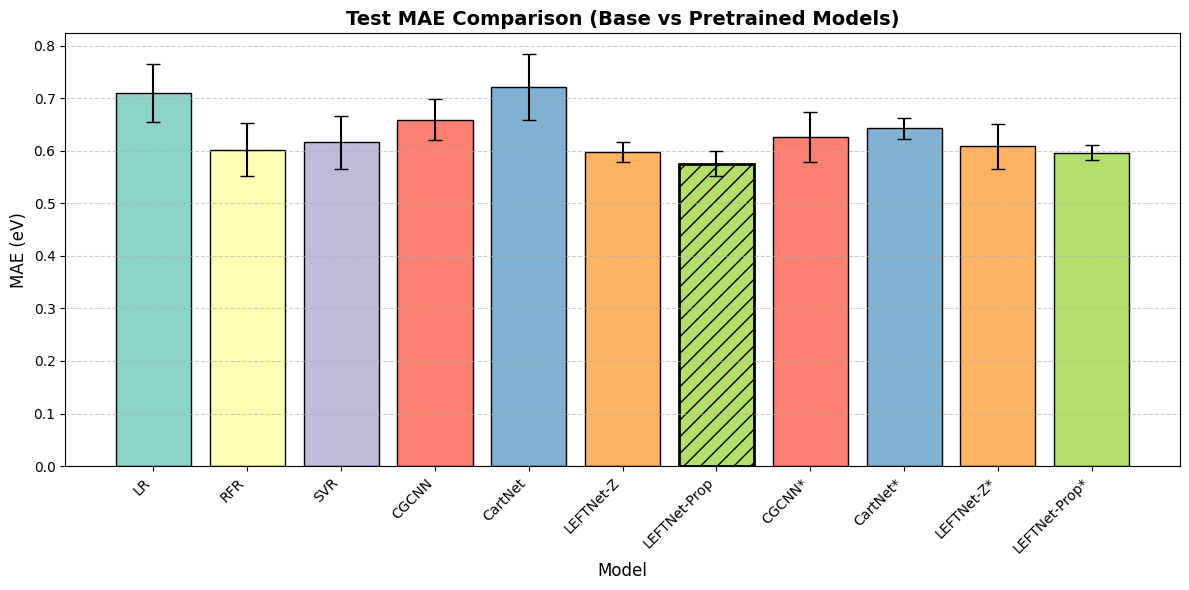

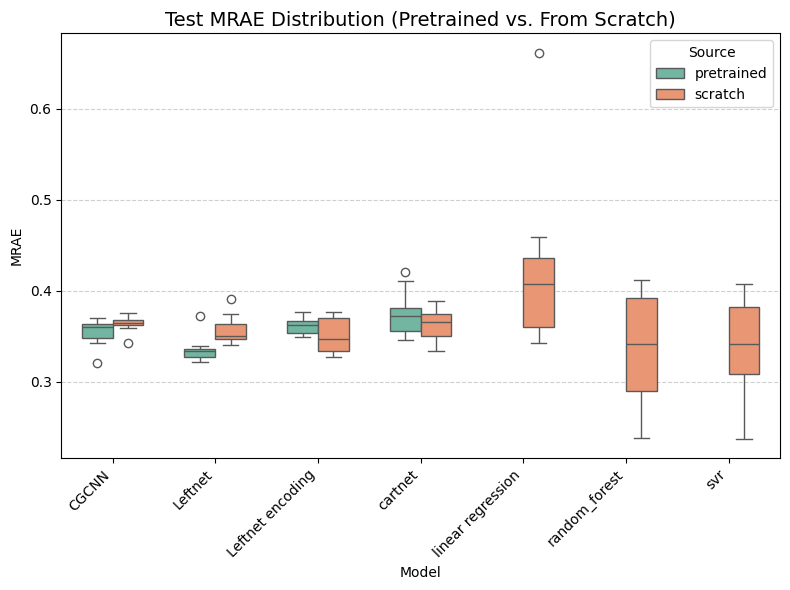

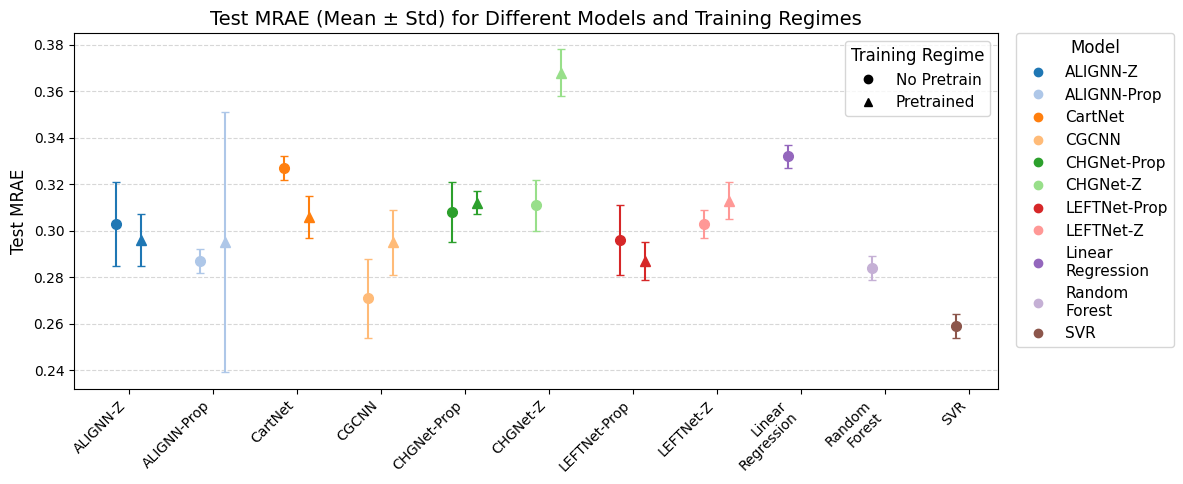